# **Preprocessing Pipeline**

## **Overview**
we have three categories:
- Normal
- Alzheimer's disease
- Parkinson's disease

We tested 23 preprocessing techniques and found that **Standard Histogram Equalization** gave the best results.

## **Data**
- 150 total brain scan images (50 from each class)
- All classes are balanced

## **Preprocessing Techniques Tested**
- **Contrast Enhancement**:
  - Standard Histogram Equalization (best)
  - Adaptive Histogram Equalization
  - CLAHE
- **Noise Reduction**:
  - Gaussian Blur
  - Bilateral Filtering
  - Median Filtering
  - Non-Local Means Denoising
- **Sharpening**:
  - Laplacian Filtering
  - Unsharp Masking
- **Combination methods** like Denoise + CLAHE + Sharpen

## **Evaluation Method**
- 5-fold cross-validation
- Random Forest classifier
- Metrics used: accuracy, precision, recall, F1-score, and training time
- Techniques ranked using a weighted scoring system

## **Best Technique: Standard Histogram Equalization**
This method improves contrast in brain images by spreading out the brightness levels. It makes it easier to see small differences and structures in the brain, which helps in identifying changes linked to Alzheimer’s and Parkinson’s.

### **Performance:**
- Cross-validation accuracy: 73.33%
- Test accuracy: 80.00%




In [2]:
# Access Data

from google.colab import drive
drive.mount('/content/drive')

import os
import random
import time
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import exposure, feature, transform, filters, restoration
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Configuration
DATA_PATH = '/content/drive/MyDrive/MLData/Data'
SAMPLE_SIZE_PER_CLASS = 50    # Sample Per Class
K_FOLDS = 5                   # Number of folds
TEST_SIZE = 0.2               # 20% for testing
RANDOM_SEED = 42
IMAGE_SIZE = (64, 64)         # Standard size for all images

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Verify the folder exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data folder not found at {DATA_PATH}. Please check the path.")

# Function to load all images or a sample
def load_images(data_path, sample_size=None):

    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    image_paths = []
    labels = []

    print(f"Found {len(classes)} classes: {classes}")

    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        all_images = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]

        print(f"Class {class_name}: {len(all_images)} images")

        if sample_size is not None:
            # Sample images if sample_size is specified
            selected_images = random.sample(all_images, min(sample_size, len(all_images)))
        else:
            # Use all images
            selected_images = all_images

        for img_name in selected_images:
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)

    print(f"Loaded total of {len(image_paths)} images from {len(classes)} classes")
    return image_paths, labels, classes

# Load images
try:
    image_paths, labels, class_names = load_images(DATA_PATH, SAMPLE_SIZE_PER_CLASS)
except Exception as e:
    print(f"Error loading images: {e}")
    raise

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3 classes: ['parkinson', 'alzheimer', 'normal']
Class parkinson: 2391 images
Class alzheimer: 2500 images
Class normal: 2699 images
Loaded total of 150 images from 3 classes


In [3]:
# Preprocessing Techniques

def original_image(img):
    """No processing"""
    return img

def grayscale_conversion(img):
    """Convert to grayscale"""
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def enhance_contrast_clahe(img):
    """Contrast Limited Adaptive Histogram Equalization"""
    # Convert to LAB color space if colored image
    if len(img.shape) == 3:
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)

        # Merge the channels back
        lab = cv2.merge((l_clahe, a, b))
        img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        return img_clahe
    else:
        # Apply CLAHE directly to grayscale
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(img)

def standard_hist_equalization(img):
    """Standard Histogram Equalization"""
    if len(img.shape) == 3:
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    else:
        return cv2.equalizeHist(img)

def adaptive_equalization(img):
    """Adaptive Histogram Equalization using skimage"""
    if len(img.shape) == 3:
        # Convert to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        # Enhance value channel
        v_eq = exposure.equalize_adapthist(v, clip_limit=0.03)
        v_eq = (v_eq * 255).astype(np.uint8)

        # Recombine
        hsv_eq = cv2.merge([h, s, v_eq])
        return cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2BGR)
    else:
        img_eq = exposure.equalize_adapthist(img, clip_limit=0.03)
        return (img_eq * 255).astype(np.uint8)

def noise_reduction_gaussian(img):
    """Noise reduction with Gaussian Blur"""
    return cv2.GaussianBlur(img, (5, 5), 0)

def noise_reduction_bilateral(img):
    """Noise reduction with Bilateral Filter (preserves edges)"""
    if len(img.shape) == 3:
        return cv2.bilateralFilter(img, 9, 75, 75)
    else:
        return cv2.bilateralFilter(img, 9, 75, 75)

def noise_reduction_median(img):
    """Noise reduction with Median Filter (good for salt-and-pepper noise)"""
    return cv2.medianBlur(img, 5)

def noise_reduction_nlm(img):
    """Non-Local Means Denoising"""
    if len(img.shape) == 3:
        return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    else:
        return cv2.fastNlMeansDenoising(img, None, 10, 7, 21)

def image_sharpening(img):
    """Sharpen image using unsharp masking"""
    blur = cv2.GaussianBlur(img, (0, 0), 3)
    return cv2.addWeighted(img, 1.5, blur, -0.5, 0)

def image_sharpening_laplacian(img):
    """Sharpen image using Laplacian filter"""
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def gamma_correction(img, gamma=1.2):
    """Apply gamma correction to adjust brightness"""
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, 1.0 / gamma) * 255.0, 0, 255)
    return cv2.LUT(img, lookUpTable)

def edge_enhancement(img):
    """Enhance edges in the image"""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    edges = cv2.Canny(gray, 50, 150)

    if len(img.shape) == 3:
        return cv2.addWeighted(img, 1, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.2, 0)
    else:
        return cv2.addWeighted(img, 1, edges, 0.2, 0)

def normalization(img):
    """Normalize pixel values to 0-255 range"""
    norm_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return norm_img



# Technique Combinations

def clahe_sharpen(img):
    """CLAHE followed by sharpening"""
    clahe_img = enhance_contrast_clahe(img)
    return image_sharpening_laplacian(clahe_img)

def denoise_clahe_sharpen(img):
    """Denoise, then CLAHE, then sharpen"""
    denoised = noise_reduction_bilateral(img)
    clahe_img = enhance_contrast_clahe(denoised)
    return image_sharpening_laplacian(clahe_img)

def median_sharpen(img):
    """Median filter followed by sharpening"""
    median_img = noise_reduction_median(img)
    return image_sharpening_laplacian(median_img)

def edge_enhance_sharpen(img):
    """Edge enhancement followed by sharpening"""
    edge_img = edge_enhancement(img)
    return image_sharpening_laplacian(edge_img)

def denoise_normalize_clahe(img):
    """Denoise, normalize, then CLAHE"""
    denoised = noise_reduction_nlm(img)
    normalized = normalization(denoised)
    return enhance_contrast_clahe(normalized)

def gamma_clahe_sharpen(img):
    """Gamma correction, CLAHE, then sharpen"""
    gamma_img = gamma_correction(img, gamma=1.2)
    clahe_img = enhance_contrast_clahe(gamma_img)
    return image_sharpening_laplacian(clahe_img)

def clahe_gamma_sharpen(img):
    """CLAHE, then gamma correction, then sharpening"""
    clahe_img = enhance_contrast_clahe(img)
    gamma_img = gamma_correction(clahe_img, gamma=1.2)
    return image_sharpening_laplacian(gamma_img)

def median_clahe_sharpen(img):
    """Median filter for noise, then CLAHE, then sharpen"""
    median_img = noise_reduction_median(img)
    clahe_img = enhance_contrast_clahe(median_img)
    return image_sharpening_laplacian(clahe_img)

def gaussian_clahe_gamma(img):
    """Gaussian blur, CLAHE, gamma correction"""
    blurred = noise_reduction_gaussian(img)
    clahe_img = enhance_contrast_clahe(blurred)
    return gamma_correction(clahe_img, gamma=1.1)

def nlm_clahe_unsharp(img):
    """NLM denoising, CLAHE, unsharp mask for sharpening"""
    denoised = noise_reduction_nlm(img)
    clahe_img = enhance_contrast_clahe(denoised)
    return image_sharpening(clahe_img)

def normalize_gamma_clahe(img):
    """Normalize, gamma correction, then CLAHE"""
    normalized = normalization(img)
    gamma_img = gamma_correction(normalized, gamma=1.2)
    return enhance_contrast_clahe(gamma_img)

def bilateral_adaptive_sharpen(img):
    """Bilateral filter, adaptive histogram equalization, sharpen"""
    filtered = noise_reduction_bilateral(img)
    equalized = adaptive_equalization(filtered)
    return image_sharpening_laplacian(equalized)

def clahe_edge_sharpen(img):
    """CLAHE, edge enhancement, sharpen"""
    clahe_img = enhance_contrast_clahe(img)
    edge_img = edge_enhancement(clahe_img)
    return image_sharpening_laplacian(edge_img)


In [4]:
# Preprocessing Pipeline with Cross-Validation

def process_and_evaluate_images(image_paths, labels, test_mode=False):

    # Define preprocessing techniques to test
    techniques = {
        'Original': original_image,
        'CLAHE': enhance_contrast_clahe,
        'Hist Equalization': standard_hist_equalization,
        'Adaptive Equalization': adaptive_equalization,
        'Gaussian Blur': noise_reduction_gaussian,
        'Bilateral Filter': noise_reduction_bilateral,
        'Median Filter': noise_reduction_median,
        'NLM Denoising': noise_reduction_nlm,
        'Sharpen (Unsharp)': image_sharpening,
        'Sharpen (Laplacian)': image_sharpening_laplacian,
        'Gamma Correction': gamma_correction,
        'CLAHE + Sharpen': clahe_sharpen,
        'Denoise + CLAHE + Sharpen': denoise_clahe_sharpen,
        'Median + Sharpen': median_sharpen,
        'Edge Enhance + Sharpen': edge_enhance_sharpen,
        'Denoise + Normalize + CLAHE': denoise_normalize_clahe,
        'Gamma + CLAHE + Sharpen': gamma_clahe_sharpen,
        'CLAHE + Gamma + Sharpen': clahe_gamma_sharpen,
        'Median + CLAHE + Sharpen': median_clahe_sharpen,
        'Gaussian + CLAHE + Gamma': gaussian_clahe_gamma,
        'NLM + CLAHE + Unsharp': nlm_clahe_unsharp,
        'Normalize + Gamma + CLAHE': normalize_gamma_clahe,
        'Bilateral + Adaptive + Sharpen': bilateral_adaptive_sharpen,
        'CLAHE + Edge Enhance + Sharpen': clahe_edge_sharpen,
    }

    # If in test mode, use only a subset of techniques
    if test_mode:
        techniques = {k: techniques[k] for k in list(techniques.keys())[:5]}
        print(f"TEST MODE: Using only {len(techniques)} techniques")

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(labels)

    results = []

    # Process images with each technique
    for name, preprocess_func in techniques.items():
        print(f"\nProcessing with {name}...")
        X = []
        processed_labels = []

        # Process each image
        for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc=f"Processing {name}"):
            try:
                img = cv2.imread(path)
                if img is None:
                    print(f"Warning: Could not read {path}")
                    continue

                # Apply preprocessing
                processed = preprocess_func(img)

                # Resize to standard size
                resized = cv2.resize(processed, IMAGE_SIZE)

                # Ensure image has correct dimensions
                if len(resized.shape) == 2:
                    resized = np.stack((resized,)*3, axis=-1)

                # Flatten for classifier
                X.append(resized.flatten())
                processed_labels.append(label)

            except Exception as e:
                print(f"Error processing {path} with {name}: {e}")
                continue

        if len(X) == 0:
            print(f"No images successfully processed with {name}. Skipping.")
            continue

        X = np.array(X)
        y_processed = le.transform(processed_labels)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_processed, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_processed
        )

        # Train and evaluate with cross-validation
        clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=RANDOM_SEED, n_jobs=-1)

        # Measure training time
        start_time = time.time()

        # Cross-validation for more robust evaluation
        cv = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

        # Train on full training set
        clf.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Evaluate on test set
        y_pred = clf.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)

        # Generate detailed metrics
        class_report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Store results
        result = {
            'technique': name,
            'cv_accuracy_mean': cv_scores.mean(),
            'cv_accuracy_std': cv_scores.std(),
            'test_accuracy': test_accuracy,
            'training_time': training_time,
            'precision': class_report['weighted avg']['precision'],
            'recall': class_report['weighted avg']['recall'],
            'f1_score': class_report['weighted avg']['f1-score']
        }

        results.append(result)

        # Print summary
        print(f"Cross-validation accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        print(f"Test accuracy: {test_accuracy:.3f}")
        print(f"Training time: {training_time:.2f}s")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))

    return pd.DataFrame(results), le

# Process and evaluate all techniques
metrics_df, label_encoder = process_and_evaluate_images(image_paths, labels)


Processing with Original...


Processing Original: 100%|██████████| 150/150 [01:35<00:00,  1.57it/s]


Cross-validation accuracy: 0.692 ± 0.042
Test accuracy: 0.733
Training time: 7.24s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.62      0.50      0.56        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.72        30
weighted avg       0.72      0.73      0.72        30


Processing with CLAHE...


Processing CLAHE: 100%|██████████| 150/150 [00:01<00:00, 96.92it/s] 


Cross-validation accuracy: 0.642 ± 0.097
Test accuracy: 0.733
Training time: 2.10s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.62      0.50      0.56        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.72        30
weighted avg       0.72      0.73      0.72        30


Processing with Hist Equalization...


Processing Hist Equalization: 100%|██████████| 150/150 [00:00<00:00, 158.01it/s]


Cross-validation accuracy: 0.733 ± 0.042
Test accuracy: 0.800
Training time: 3.33s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.67      0.80      0.73        10
      normal       0.75      0.60      0.67        10
   parkinson       1.00      1.00      1.00        10

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30


Processing with Adaptive Equalization...


Processing Adaptive Equalization: 100%|██████████| 150/150 [00:02<00:00, 58.91it/s]


Cross-validation accuracy: 0.650 ± 0.042
Test accuracy: 0.700
Training time: 4.29s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.67      0.80      0.73        10
      normal       0.60      0.30      0.40        10
   parkinson       0.77      1.00      0.87        10

    accuracy                           0.70        30
   macro avg       0.68      0.70      0.67        30
weighted avg       0.68      0.70      0.67        30


Processing with Gaussian Blur...


Processing Gaussian Blur: 100%|██████████| 150/150 [00:01<00:00, 109.36it/s]


Cross-validation accuracy: 0.700 ± 0.031
Test accuracy: 0.767
Training time: 2.79s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.73      0.80      0.76        10
      normal       0.71      0.50      0.59        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.77        30
   macro avg       0.76      0.77      0.75        30
weighted avg       0.76      0.77      0.75        30


Processing with Bilateral Filter...


Processing Bilateral Filter: 100%|██████████| 150/150 [00:02<00:00, 68.03it/s]


Cross-validation accuracy: 0.708 ± 0.046
Test accuracy: 0.767
Training time: 2.73s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.73      0.80      0.76        10
      normal       0.71      0.50      0.59        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.77        30
   macro avg       0.76      0.77      0.75        30
weighted avg       0.76      0.77      0.75        30


Processing with Median Filter...


Processing Median Filter: 100%|██████████| 150/150 [00:01<00:00, 104.38it/s]


Cross-validation accuracy: 0.692 ± 0.020
Test accuracy: 0.733
Training time: 4.88s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.62      0.50      0.56        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.72        30
weighted avg       0.72      0.73      0.72        30


Processing with NLM Denoising...


Processing NLM Denoising: 100%|██████████| 150/150 [00:29<00:00,  5.02it/s]


Cross-validation accuracy: 0.708 ± 0.000
Test accuracy: 0.700
Training time: 2.03s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.57      0.40      0.47        10
   parkinson       0.77      1.00      0.87        10

    accuracy                           0.70        30
   macro avg       0.68      0.70      0.68        30
weighted avg       0.68      0.70      0.68        30


Processing with Sharpen (Unsharp)...


Processing Sharpen (Unsharp): 100%|██████████| 150/150 [00:01<00:00, 101.36it/s]


Cross-validation accuracy: 0.692 ± 0.042
Test accuracy: 0.667
Training time: 4.07s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.64      0.70      0.67        10
      normal       0.50      0.30      0.38        10
   parkinson       0.77      1.00      0.87        10

    accuracy                           0.67        30
   macro avg       0.64      0.67      0.64        30
weighted avg       0.64      0.67      0.64        30


Processing with Sharpen (Laplacian)...


Processing Sharpen (Laplacian): 100%|██████████| 150/150 [00:01<00:00, 121.47it/s]


Cross-validation accuracy: 0.633 ± 0.049
Test accuracy: 0.667
Training time: 4.05s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.62      0.50      0.56        10
      normal       0.50      0.50      0.50        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.67        30
   macro avg       0.65      0.67      0.65        30
weighted avg       0.65      0.67      0.65        30


Processing with Gamma Correction...


Processing Gamma Correction: 100%|██████████| 150/150 [00:01<00:00, 128.11it/s]


Cross-validation accuracy: 0.700 ± 0.017
Test accuracy: 0.700
Training time: 2.05s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.64      0.70      0.67        10
      normal       0.57      0.40      0.47        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.70        30
   macro avg       0.68      0.70      0.68        30
weighted avg       0.68      0.70      0.68        30


Processing with CLAHE + Sharpen...


Processing CLAHE + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 128.97it/s]


Cross-validation accuracy: 0.675 ± 0.061
Test accuracy: 0.633
Training time: 2.17s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.64      0.70      0.67        10
      normal       0.40      0.20      0.27        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.63        30
   macro avg       0.58      0.63      0.59        30
weighted avg       0.58      0.63      0.59        30


Processing with Denoise + CLAHE + Sharpen...


Processing Denoise + CLAHE + Sharpen: 100%|██████████| 150/150 [00:02<00:00, 71.30it/s]


Cross-validation accuracy: 0.708 ± 0.059
Test accuracy: 0.600
Training time: 2.91s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.60      0.60      0.60        10
      normal       0.33      0.20      0.25        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.60        30
   macro avg       0.55      0.60      0.56        30
weighted avg       0.55      0.60      0.56        30


Processing with Median + Sharpen...


Processing Median + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 124.53it/s]


Cross-validation accuracy: 0.692 ± 0.042
Test accuracy: 0.733
Training time: 2.48s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.62      0.50      0.56        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.72        30
weighted avg       0.72      0.73      0.72        30


Processing with Edge Enhance + Sharpen...


Processing Edge Enhance + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 133.85it/s]


Cross-validation accuracy: 0.675 ± 0.081
Test accuracy: 0.600
Training time: 2.07s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.60      0.60      0.60        10
      normal       0.33      0.20      0.25        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.60        30
   macro avg       0.55      0.60      0.56        30
weighted avg       0.55      0.60      0.56        30


Processing with Denoise + Normalize + CLAHE...


Processing Denoise + Normalize + CLAHE: 100%|██████████| 150/150 [00:24<00:00,  6.23it/s]


Cross-validation accuracy: 0.725 ± 0.050
Test accuracy: 0.733
Training time: 2.03s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.75      0.90      0.82        10
      normal       0.75      0.30      0.43        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.69        30
weighted avg       0.74      0.73      0.69        30


Processing with Gamma + CLAHE + Sharpen...


Processing Gamma + CLAHE + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 102.94it/s]


Cross-validation accuracy: 0.658 ± 0.041
Test accuracy: 0.733
Training time: 2.17s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.67      0.80      0.73        10
      normal       0.67      0.40      0.50        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.71        30
weighted avg       0.72      0.73      0.71        30


Processing with CLAHE + Gamma + Sharpen...


Processing CLAHE + Gamma + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 102.16it/s]


Cross-validation accuracy: 0.675 ± 0.081
Test accuracy: 0.667
Training time: 2.19s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.67      0.80      0.73        10
      normal       0.50      0.20      0.29        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.67        30
   macro avg       0.63      0.67      0.62        30
weighted avg       0.63      0.67      0.62        30


Processing with Median + CLAHE + Sharpen...


Processing Median + CLAHE + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 90.62it/s] 


Cross-validation accuracy: 0.675 ± 0.049
Test accuracy: 0.767
Training time: 3.24s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.73      0.80      0.76        10
      normal       0.71      0.50      0.59        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.77        30
   macro avg       0.76      0.77      0.75        30
weighted avg       0.76      0.77      0.75        30


Processing with Gaussian + CLAHE + Gamma...


Processing Gaussian + CLAHE + Gamma: 100%|██████████| 150/150 [00:01<00:00, 105.22it/s]


Cross-validation accuracy: 0.650 ± 0.101
Test accuracy: 0.733
Training time: 2.12s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.67      0.80      0.73        10
      normal       0.67      0.40      0.50        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.71        30
weighted avg       0.72      0.73      0.71        30


Processing with NLM + CLAHE + Unsharp...


Processing NLM + CLAHE + Unsharp: 100%|██████████| 150/150 [00:22<00:00,  6.55it/s]


Cross-validation accuracy: 0.700 ± 0.031
Test accuracy: 0.667
Training time: 2.70s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.50      0.30      0.38        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.67        30
   macro avg       0.64      0.67      0.64        30
weighted avg       0.64      0.67      0.64        30


Processing with Normalize + Gamma + CLAHE...


Processing Normalize + Gamma + CLAHE: 100%|██████████| 150/150 [00:01<00:00, 81.87it/s] 


Cross-validation accuracy: 0.667 ± 0.095
Test accuracy: 0.700
Training time: 2.10s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.57      0.40      0.47        10
   parkinson       0.77      1.00      0.87        10

    accuracy                           0.70        30
   macro avg       0.68      0.70      0.68        30
weighted avg       0.68      0.70      0.68        30


Processing with Bilateral + Adaptive + Sharpen...


Processing Bilateral + Adaptive + Sharpen: 100%|██████████| 150/150 [00:03<00:00, 48.91it/s]


Cross-validation accuracy: 0.708 ± 0.070
Test accuracy: 0.700
Training time: 2.64s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.78      0.70      0.74        10
      normal       0.57      0.40      0.47        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.70        30
   macro avg       0.69      0.70      0.68        30
weighted avg       0.69      0.70      0.68        30


Processing with CLAHE + Edge Enhance + Sharpen...


Processing CLAHE + Edge Enhance + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 98.15it/s] 


Cross-validation accuracy: 0.633 ± 0.041
Test accuracy: 0.600
Training time: 3.02s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.58      0.70      0.64        10
      normal       0.25      0.10      0.14        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.60        30
   macro avg       0.52      0.60      0.54        30
weighted avg       0.52      0.60      0.54        30




Technique Comparison (Ranked by Overall Score):
                         technique  cv_accuracy_mean  test_accuracy  f1_score  \
2                Hist Equalization            0.7333          0.800     0.798   
5                 Bilateral Filter            0.7083          0.767     0.753   
15     Denoise + Normalize + CLAHE            0.7250          0.733     0.693   
4                    Gaussian Blur            0.7000          0.767     0.753   
7                    NLM Denoising            0.7083          0.700     0.680   
13                Median + Sharpen            0.6917          0.733     0.722   
18        Median + CLAHE + Sharpen            0.6750          0.767     0.753   
22  Bilateral + Adaptive + Sharpen            0.7083          0.700     0.680   
10                Gamma Correction            0.7000          0.700     0.682   
6                    Median Filter            0.6917          0.733     0.722   
16         Gamma + CLAHE + Sharpen            0.6583        

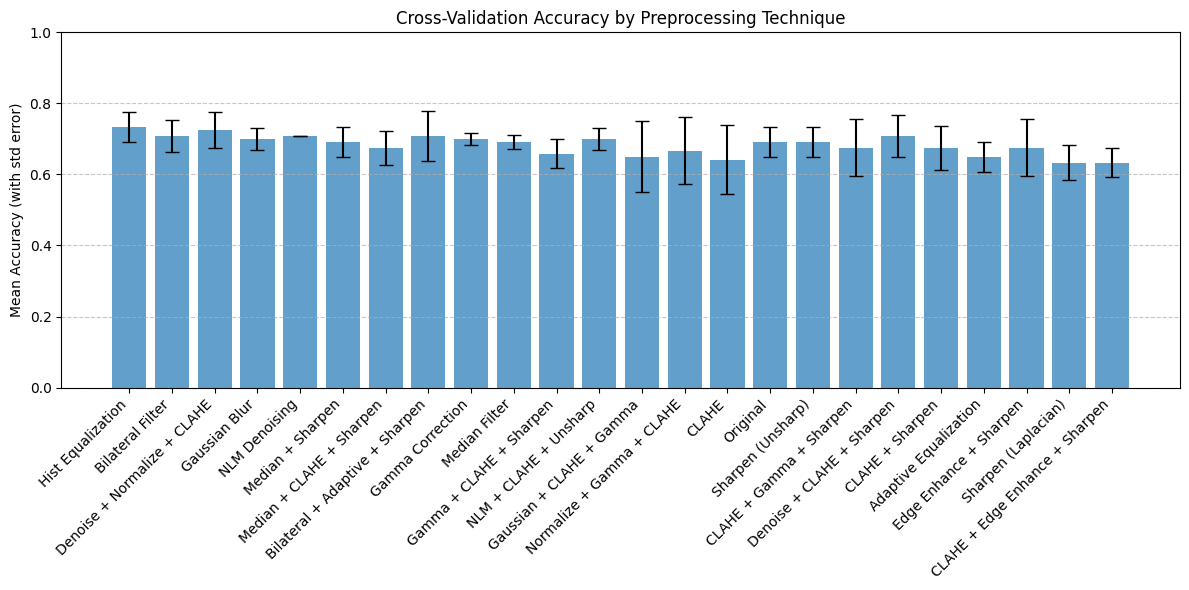

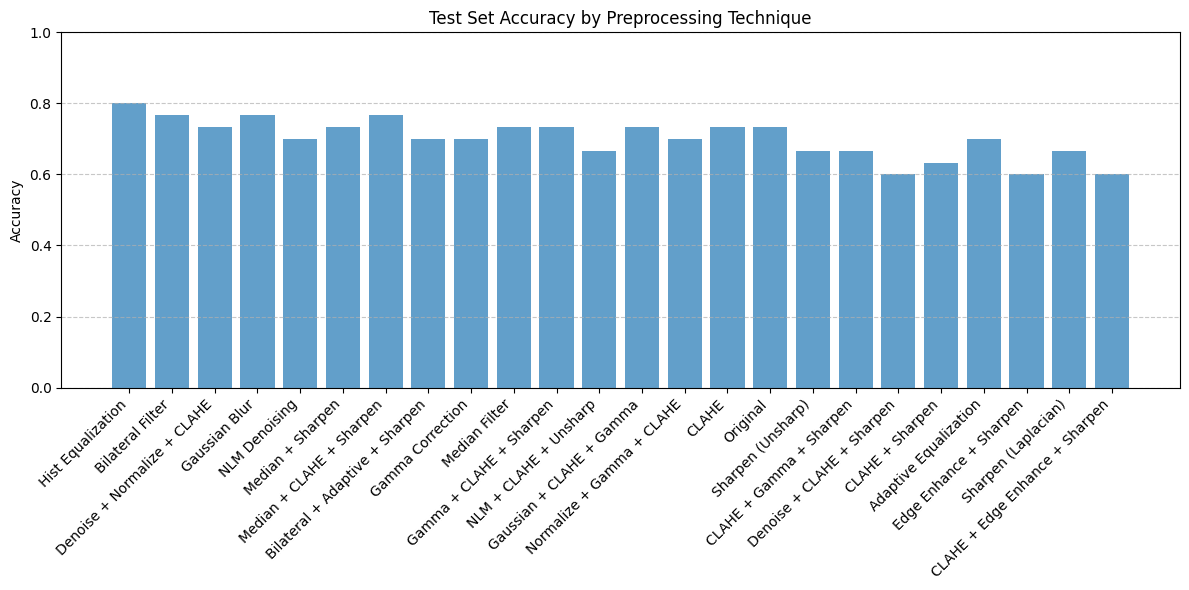

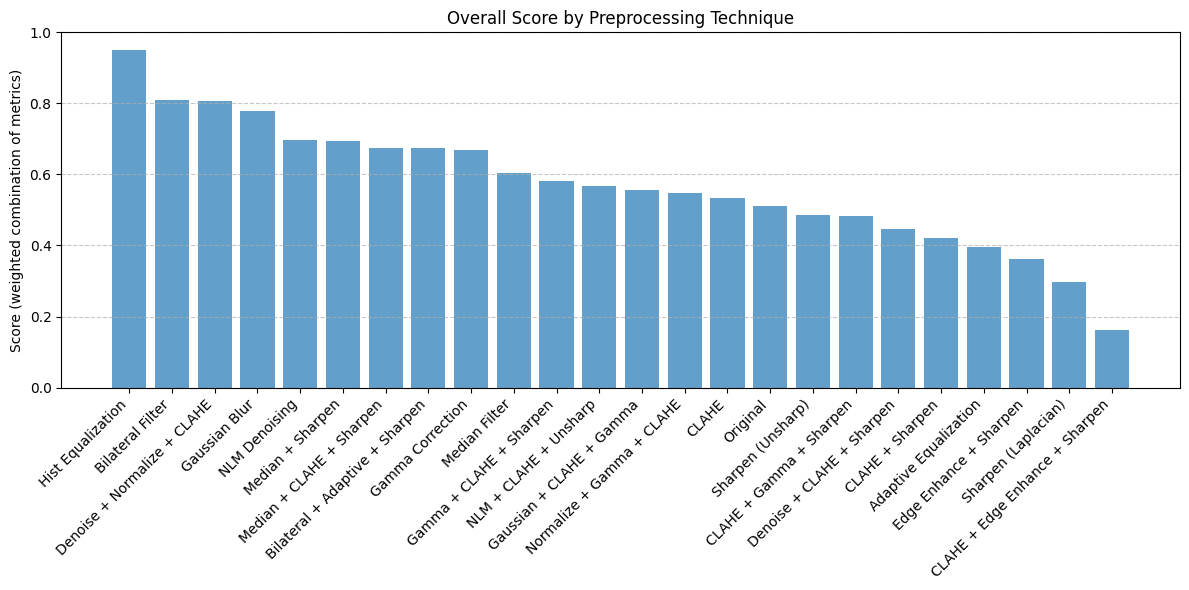

In [9]:
# Compare and Visualize Results

def compare_techniques(metrics_df):

    # Calculate normalized scores for each metric (higher is better)
    metrics = ['cv_accuracy_mean', 'test_accuracy', 'precision', 'recall', 'f1_score']

    for metric in metrics:
        min_val = metrics_df[metric].min()
        max_val = metrics_df[metric].max()
        metrics_df[f'norm_{metric}'] = (metrics_df[metric] - min_val) / (max_val - min_val) if max_val > min_val else 0

    # Normalize training time (lower is better)
    min_time = metrics_df['training_time'].min()
    max_time = metrics_df['training_time'].max()
    if max_time > min_time:
        metrics_df['norm_time'] = 1 - ((metrics_df['training_time'] - min_time) / (max_time - min_time))
    else:
        metrics_df['norm_time'] = 1.0

    # Calculate weighted score (can adjust weights based on priorities)
    weights = {
        'cv_accuracy_mean': 0.35,  # Cross-validation accuracy is most important
        'test_accuracy': 0.25,     # Test accuracy also important
        'f1_score': 0.20,          # F1 score captures precision/recall balance
        'training_time': 0.20      # Efficiency matters but not as much as accuracy
    }

    metrics_df['overall_score'] = (
        weights['cv_accuracy_mean'] * metrics_df['norm_cv_accuracy_mean'] +
        weights['test_accuracy'] * metrics_df['norm_test_accuracy'] +
        weights['f1_score'] * metrics_df['norm_f1_score'] +
        weights['training_time'] * metrics_df['norm_time']
    )

    # Format metrics for display
    for metric in metrics + ['training_time']:
        if metric in ['cv_accuracy_mean', 'cv_accuracy_std']:
            metrics_df[metric] = metrics_df[metric].round(4)
        else:
            metrics_df[metric] = metrics_df[metric].round(3)

    return metrics_df.sort_values('overall_score', ascending=False)

# Compare the techniques
comparison_df = compare_techniques(metrics_df)

# Print the comparison results
print("\nTechnique Comparison (Ranked by Overall Score):")
print(comparison_df[['technique', 'cv_accuracy_mean', 'test_accuracy', 'f1_score', 'training_time', 'overall_score']])

# Find the best technique
best_technique = comparison_df.iloc[0]['technique']
best_cv_accuracy = comparison_df.iloc[0]['cv_accuracy_mean']
best_test_accuracy = comparison_df.iloc[0]['test_accuracy']

print(f"\nRecommended preprocessing technique: {best_technique}")
print(f"Cross-validation accuracy: {best_cv_accuracy:.4f}")
print(f"Test accuracy: {best_test_accuracy:.3f}")
print("This recommendation is based on cross-validation accuracy, test accuracy, F1 score, and training time.")





# Visualize Results

# Bar chart of cross-validation accuracies
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['technique'], comparison_df['cv_accuracy_mean'],
        yerr=comparison_df['cv_accuracy_std'], alpha=0.7, capsize=5)
plt.title('Cross-Validation Accuracy by Preprocessing Technique')
plt.ylabel('Mean Accuracy (with std error)')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('preprocessing_cv_accuracy.png')
plt.show()

# Bar chart of test accuracies
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['technique'], comparison_df['test_accuracy'], alpha=0.7)
plt.title('Test Set Accuracy by Preprocessing Technique')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('preprocessing_test_accuracy.png')
plt.show()

# Overall score comparison
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['technique'], comparison_df['overall_score'], alpha=0.7)
plt.title('Overall Score by Preprocessing Technique')
plt.ylabel('Score (weighted combination of metrics)')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('preprocessing_overall_score.png')
plt.show()

/content/drive/MyDrive/MLData/Data/alzheimer/verymild_672.jpg


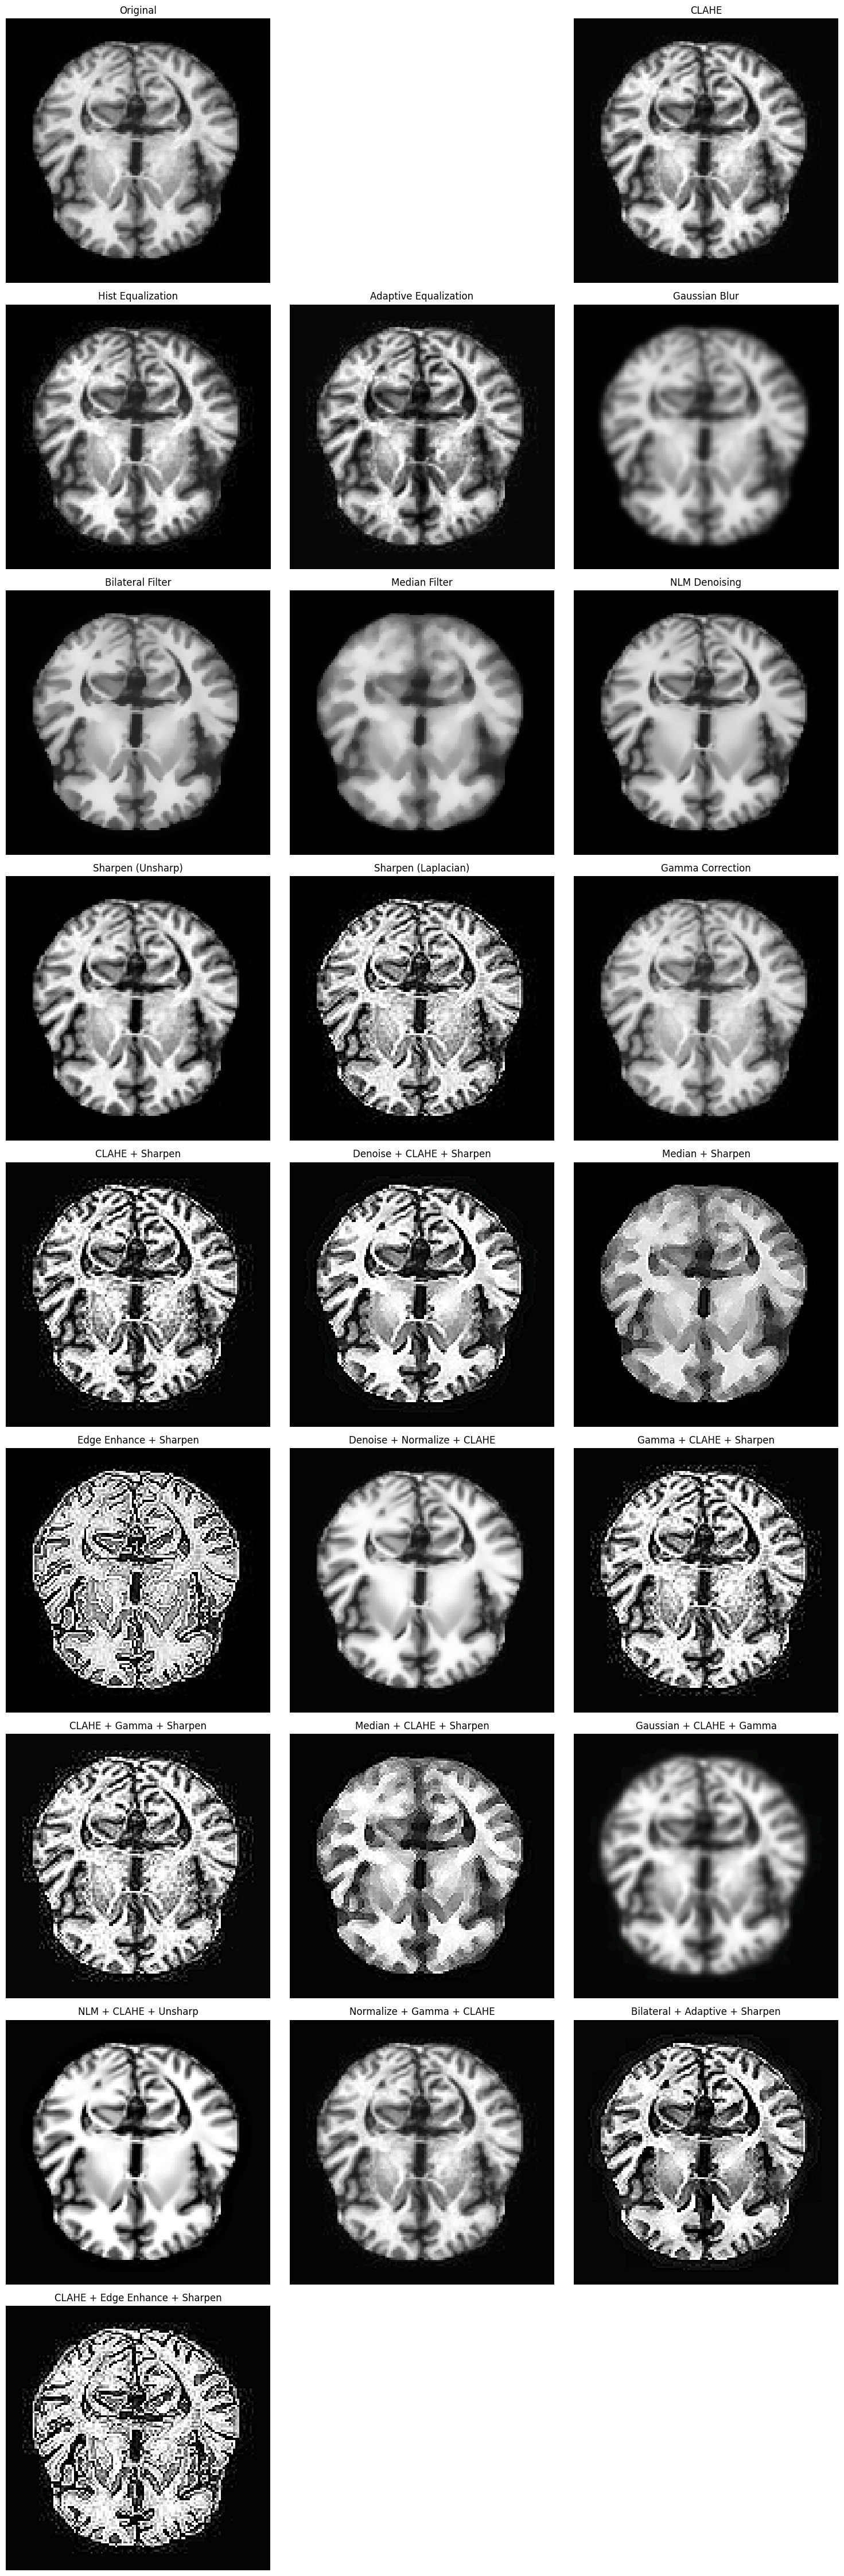

In [7]:
# Show Images with Preproccessing

def visualize_preprocessing_techniques(image_path, techniques=None):

    # Load a sample image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return

    # Define all available techniques if not specified
    if techniques is None:
        techniques = {
            'Original': original_image,
            'CLAHE': enhance_contrast_clahe,
            'Hist Equalization': standard_hist_equalization,
            'Adaptive Equalization': adaptive_equalization,
            'Gaussian Blur': noise_reduction_gaussian,
            'Bilateral Filter': noise_reduction_bilateral,
            'Median Filter': noise_reduction_median,
            'NLM Denoising': noise_reduction_nlm,
            'Sharpen (Unsharp)': image_sharpening,
            'Sharpen (Laplacian)': image_sharpening_laplacian,
            'Gamma Correction': gamma_correction,
            'CLAHE + Sharpen': clahe_sharpen,
            'Denoise + CLAHE + Sharpen': denoise_clahe_sharpen,
            'Median + Sharpen': median_sharpen,
            'Edge Enhance + Sharpen': edge_enhance_sharpen,
            'Denoise + Normalize + CLAHE': denoise_normalize_clahe,
            'Gamma + CLAHE + Sharpen': gamma_clahe_sharpen,
            'CLAHE + Gamma + Sharpen': clahe_gamma_sharpen,
          'Median + CLAHE + Sharpen': median_clahe_sharpen,
          'Gaussian + CLAHE + Gamma': gaussian_clahe_gamma,
          'NLM + CLAHE + Unsharp': nlm_clahe_unsharp,
          'Normalize + Gamma + CLAHE': normalize_gamma_clahe,
          'Bilateral + Adaptive + Sharpen': bilateral_adaptive_sharpen,
          'CLAHE + Edge Enhance + Sharpen': clahe_edge_sharpen,
        }

    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Calculate grid size
    n_techniques = len(techniques)
    n_cols = 3
    n_rows = (n_techniques + 1) // n_cols + 1  # +1 for original image

    # Create figure
    plt.figure(figsize=(5*n_cols, 5*n_rows))

    # Show original image
    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(img_rgb)
    plt.title('Original')
    plt.axis('off')

    # Process and display each technique
    for i, (name, func) in enumerate(techniques.items(), 1):
        if name == 'Original':
            continue  # Skip original as we already displayed it

        try:
            processed = func(img)

            if len(processed.shape) == 2:  # If grayscale
                plt.subplot(n_rows, n_cols, i+1)
                plt.imshow(processed, cmap='gray')
                plt.title(name)
                plt.axis('off')
            else:  # If color
                processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
                plt.subplot(n_rows, n_cols, i+1)
                plt.imshow(processed_rgb)
                plt.title(name)
                plt.axis('off')
        except Exception as e:
            print(f"Error visualizing {name}: {e}")

    plt.tight_layout()
    plt.savefig('preprocessing_visualization.png')
    plt.show()



# Test With an image
image_path = image_paths[52]
print(image_path)
visualize_preprocessing_techniques(image_path)

In [8]:
# Summary report

print("\n=== SUMMARY ===")
print(f"Total images analyzed: {len(image_paths)}")
print(f"Classes: {', '.join(class_names)}")
print(f"Number of preprocessing techniques evaluated: {len(metrics_df)}")
print(f"Best preprocessing technique: {best_technique}")
print(f"Cross-validation accuracy: {best_cv_accuracy:.4f}")
print(f"Test accuracy: {best_test_accuracy:.3f}")
print("Analysis complete.")


=== SUMMARY ===
Total images analyzed: 150
Classes: parkinson, alzheimer, normal
Number of preprocessing techniques evaluated: 24
Best preprocessing technique: Hist Equalization
Cross-validation accuracy: 0.7333
Test accuracy: 0.800
Analysis complete.


In [10]:
# Final Preprocessing

def final_preprocessing(image_paths):

    processed_images = []

    for path in tqdm(image_paths, desc="Applying final preprocessing"):
        try:
            img = cv2.imread(path)
            if img is None:
                print(f"Warning: Could not read {path}")
                continue

            # Apply your histogram equalization function
            equalized_img = standard_hist_equalization(img)

            # Resize to standard size
            resized_img = cv2.resize(equalized_img, IMAGE_SIZE)

            # Ensure correct dimensions
            if len(resized_img.shape) == 2:
                resized_img = np.stack((resized_img,) * 3, axis=-1)

            processed_images.append(resized_img)

        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

    return processed_images

Applying final preprocessing: 100%|██████████| 150/150 [00:02<00:00, 66.86it/s]


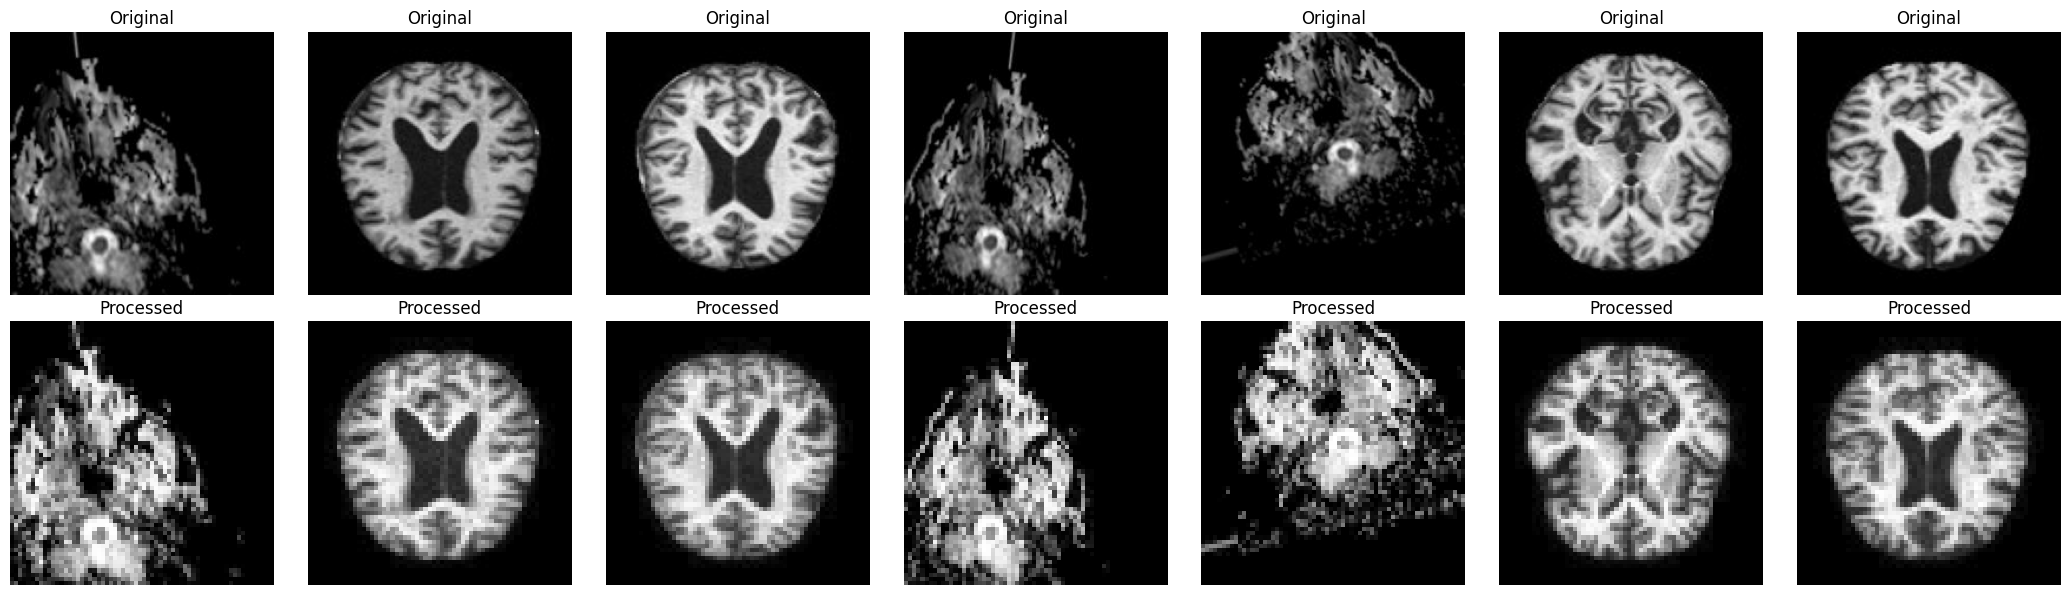

In [12]:
# Show Random Images Before and After Preprocessing

def show_random_comparison(image_paths, processed_images, num_images=5):

    assert len(image_paths) == len(processed_images), "Mismatch between image paths and processed images"
    assert num_images <= len(image_paths), "Requested more images than available"

    indices = random.sample(range(len(image_paths)), num_images)

    plt.figure(figsize=(num_images * 3, 6))

    for i, idx in enumerate(indices):
        # Read and convert original image
        original = cv2.imread(image_paths[idx])
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

        # Convert processed image to RGB
        processed_rgb = cv2.cvtColor(processed_images[idx], cv2.COLOR_BGR2RGB)

        # Show original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_rgb)
        plt.title("Original")
        plt.axis('off')

        # Show processed
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(processed_rgb)
        plt.title("Processed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Show 7 Images Randomly Before and After Preprocessing

processed_images = final_preprocessing(image_paths)
show_random_comparison(image_paths, processed_images, num_images=7)

# **Feature Extraction**

- ## **First-Order Statistical Features**

  First-order statistical features capture the distribution of pixel intensities in the MRI image. These features are important because they can reveal overall brightness, contrast, and intensity variations that may indicate tissue abnormalities.

  Key first-order features include:
  - **Mean**: Average intensity, which can indicate overall brain density
  - **Standard Deviation**: Variation in intensity, which can reflect tissue heterogeneity
  - **Skewness**: Asymmetry of the intensity distribution
  - **Kurtosis**: "Peakedness" of the intensity distribution
  - **Entropy**: Measure of randomness or unpredictability in pixel values

  These features are particularly useful for detecting general changes in brain tissue composition that occur in neurodegenerative diseases.


- ## **Gray Level Co-occurrence Matrix (GLCM) Features**

  GLCM features are second-order statistical texture features that capture spatial relationships between pixels. These features are particularly valuable for neurodegenerative disease classification because they can detect subtle texture changes in brain tissue that may not be visible to the naked eye.

  The GLCM computes how often pairs of pixels with specific values occur in a specific spatial relationship. From this matrix, we can derive several important properties:

  - **Contrast**: Measures local variations in the GLCM
  - **Correlation**: Measures joint probability occurrence of specified pixel pairs
  - **Energy/ASM**: Provides the sum of squared elements in the GLCM
  - **Homogeneity**: Measures the closeness of the distribution of elements in the GLCM to its diagonal

  Research has shown that GLCM features can effectively differentiate between AD, PD, and normal brain tissues by capturing textural differences in regions like the hippocampus, thalamus, and cortical areas.


- ## **Local Binary Pattern (LBP) Features**

  Local Binary Pattern (LBP) is a powerful texture descriptor that characterizes the local structure of an image by comparing each pixel with its neighboring pixels. LBP is particularly useful for medical image analysis because:

  1. It's computationally efficient
  2. It's invariant to monotonic gray-level changes (which makes it robust to lighting variations)
  3. It can capture micro-patterns in the image

  For neurodegenerative disease classification, LBP can detect subtle texture changes in brain tissue that occur due to neurodegeneration. Studies have shown that LBP features can effectively differentiate between AD, PD, and normal brain tissues by capturing local texture patterns in regions like the hippocampus and cortical areas.

  We'll extract LBP histograms from the images, which will serve as a compact representation of the texture patterns present in the brain MRI scans.


- ### **Wavelet Features**

  Wavelet transform is a powerful technique for analyzing images at multiple scales and orientations. By decomposing an image into different frequency components, wavelets can capture both global and local texture information.

  For neurodegenerative disease classification, wavelet features are particularly valuable because:

  1. They can detect subtle changes in brain tissue texture at different scales
  2. They can capture directional information (horizontal, vertical, and diagonal details)
  3. They provide a compact representation of the image's texture

  Research has shown that wavelet features can effectively differentiate between AD, PD, and normal brain tissues by capturing multi-scale texture information in regions like the hippocampus, cortical areas, and subcortical structures.

  We'll use the Discrete Wavelet Transform (DWT) to decompose the image into approximation, horizontal, vertical, and diagonal coefficients, and then extract statistical features from these coefficients.


- ## **Edge and Gradient Features**

  Edge and gradient features capture important structural information in brain MRI scans by highlighting boundaries between different tissue types and anatomical structures. These features are valuable for neurodegenerative disease classification because:

  1. They can detect changes in brain structure boundaries that occur due to atrophy
  2. They can highlight subtle changes in tissue interfaces that may not be visible in the original image
  3. They provide information about the direction and magnitude of intensity changes

  For diseases like Alzheimer's and Parkinson's, changes in brain structure boundaries (such as ventricle enlargement or cortical thinning) are important diagnostic indicators. Edge and gradient features can help quantify these changes.

  We'll extract features like gradient magnitude statistics, Canny edge statistics, and Sobel filter responses to capture this structural information.


- ## **Gray Level Run Length Matrix (GLRLM) Features**

  Gray Level Run Length Matrix (GLRLM) is a texture analysis method that examines runs of pixels with the same gray level value in a specific direction. A run is defined as a set of consecutive pixels with the same gray level in a specific direction.

  GLRLM features are valuable for neurodegenerative disease classification because:

  1. They can capture patterns of homogeneous regions in the brain
  2. They provide information about the coarseness or fineness of texture
  3. They can detect subtle changes in tissue texture that occur due to neurodegeneration

  Studies have shown that GLRLM features can effectively differentiate between AD, PD, and normal brain tissues by capturing run-length based texture patterns in regions like the hippocampus, thalamus, and cortical areas.

  We'll extract features like Short Run Emphasis (SRE), Long Run Emphasis (LRE), and Run Length Non-uniformity (RLN) to capture this texture information.


# **Feature Extraction Pipeline**

we'll combine all the feature extraction methods into a single pipeline. This pipeline will:

1. Load each image from the dataset
2. Extract all the features we've defined
3. Combine them into a single feature vector
4. Save the results to a CSV file for further analysis

In [26]:
# Data Loading

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, feature, filters, exposure, measure, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.transform import resize
import pywt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# New Google Drive path (replaces local path)
base_path = "/content/drive/MyDrive/MLData/Data"

# Use the same classes
classes = ["alzheimer", "parkinson", "normal"]
class_paths = {cls: os.path.join(base_path, cls) for cls in classes}

# Function to load images
def load_image(image_path):
    # Load image
    img = io.imread(image_path)

    # Convert to grayscale if it's RGB
    if len(img.shape) > 2:
        img = color.rgb2gray(img)

    # Ensure the image is in the correct format for feature extraction
    img = img_as_ubyte(img)

    return img


In [14]:
def extract_first_order_features(image):
    """Extract first-order statistical features from an image."""
    # Flatten the image to get a 1D array of pixel values
    pixels = image.flatten()

    # Calculate basic statistics
    mean = np.mean(pixels)
    std = np.std(pixels)

    # Calculate histogram
    hist, _ = np.histogram(pixels, bins=256, range=(0, 255))
    hist = hist / np.sum(hist)  # Normalize histogram

    # Calculate skewness
    skewness = np.sum(((pixels - mean) / std) ** 3) / len(pixels) if std > 0 else 0

    # Calculate kurtosis
    kurtosis = np.sum(((pixels - mean) / std) ** 4) / len(pixels) if std > 0 else 0

    # Calculate entropy
    entropy = -np.sum(hist * np.log2(hist + 1e-10))

    # Calculate percentiles
    p10 = np.percentile(pixels, 10)
    p25 = np.percentile(pixels, 25)
    p75 = np.percentile(pixels, 75)
    p90 = np.percentile(pixels, 90)

    # Calculate range
    min_val = np.min(pixels)
    max_val = np.max(pixels)
    range_val = max_val - min_val

    # Return as dictionary
    return {
        'mean': mean,
        'std': std,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'entropy': entropy,
        'p10': p10,
        'p25': p25,
        'p75': p75,
        'p90': p90,
        'min': min_val,
        'max': max_val,
        'range': range_val
    }

In [15]:
def extract_glcm_features(image, distances=[1, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Extract GLCM texture features from an image."""
    # Make sure image is in uint8 format with values 0-255
    if image.dtype != np.uint8:
        image = img_as_ubyte(image)

    # Rescale to fewer gray levels (e.g., 0-15)
    bins = 16  # Using 16 gray levels
    max_val = np.max(image)

    # Ensure max value is less than bins
    if max_val >= bins:
        # Rescale image to 0-15
        img_quantized = np.uint8(np.floor(image.astype(float) * (bins-1) / 255.0))
    else:
        img_quantized = image

    # Calculate GLCM
    glcm = graycomatrix(img_quantized, distances=distances, angles=angles,
                        levels=bins, symmetric=True, normed=True)

    # Calculate GLCM properties
    contrast = graycoprops(glcm, 'contrast').mean()
    dissimilarity = graycoprops(glcm, 'dissimilarity').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    ASM = graycoprops(glcm, 'ASM').mean()

    # Return as dictionary
    return {
        'glcm_contrast': contrast,
        'glcm_dissimilarity': dissimilarity,
        'glcm_homogeneity': homogeneity,
        'glcm_energy': energy,
        'glcm_correlation': correlation,
        'glcm_ASM': ASM
    }

In [16]:
def extract_lbp_features(image, P=8, R=1):
    """Extract Local Binary Pattern features from an image."""
    # Calculate LBP
    lbp = local_binary_pattern(image, P, R, method='uniform')

    # Calculate LBP histogram
    n_bins = P + 2  # For uniform LBP
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Create feature dictionary
    lbp_features = {}
    for i, h in enumerate(hist):
        lbp_features[f'lbp_bin_{i}'] = h

    return lbp_features

In [17]:
def extract_wavelet_features(image):
    """Extract wavelet features from an image."""
    # Apply wavelet transform
    coeffs = pywt.dwt2(image, 'db1')
    LL, (LH, HL, HH) = coeffs

    # Extract statistical features from each sub-band
    wavelet_features = {}

    for name, coeff in zip(['LL', 'LH', 'HL', 'HH'], [LL, LH, HL, HH]):
        # Calculate basic statistics
        mean = np.mean(coeff)
        std = np.std(coeff)
        energy = np.sum(coeff**2) / coeff.size
        entropy = -np.sum((coeff**2) * np.log2(coeff**2 + 1e-10)) / coeff.size

        wavelet_features[f'wavelet_{name}_mean'] = mean
        wavelet_features[f'wavelet_{name}_std'] = std
        wavelet_features[f'wavelet_{name}_energy'] = energy
        wavelet_features[f'wavelet_{name}_entropy'] = entropy

    return wavelet_features

In [18]:
def extract_edge_gradient_features(image):
    """Extract edge and gradient features from an image."""
    # Calculate gradient using Sobel operator
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate gradient magnitude and direction
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    direction = np.arctan2(sobely, sobelx)

    # Calculate Canny edges
    edges = feature.canny(image, sigma=1)

    # Extract features
    features = {
        'gradient_mean': np.mean(magnitude),
        'gradient_std': np.std(magnitude),
        'gradient_energy': np.sum(magnitude**2) / magnitude.size,
        'gradient_entropy': -np.sum((magnitude**2) * np.log2(magnitude**2 + 1e-10)) / magnitude.size,
        'direction_mean': np.mean(direction),
        'direction_std': np.std(direction),
        'edge_density': np.sum(edges) / edges.size
    }

    return features

In [19]:
def extract_glrlm_features(image):
    """Extract Gray Level Run Length Matrix features from an image without using mahotas."""
    # Quantize the image to fewer gray levels
    bins = 16
    img_quantized = np.digitize(image, np.linspace(0, 255, bins+1)) - 1

    # Define directions for run length calculation
    directions = [(1, 0),   # horizontal
                  (0, 1),   # vertical
                  (1, 1),   # diagonal
                  (1, -1)]  # anti-diagonal

    features = {}

    # Calculate run length features for each direction
    for idx, (dx, dy) in enumerate(directions):
        # Initialize counters
        short_runs = 0
        long_runs = 0
        total_runs = 0
        run_lengths = []

        # Process the image
        rows, cols = img_quantized.shape
        for i in range(rows):
            for j in range(cols):
                # Skip if we've already processed this pixel as part of a run
                if img_quantized[i, j] == -1:
                    continue

                # Start a new run
                run_val = img_quantized[i, j]
                run_length = 0

                # Follow the run in the current direction
                x, y = j, i
                while (0 <= x < cols and 0 <= y < rows and
                       img_quantized[y, x] == run_val):
                    # Mark as processed
                    img_quantized[y, x] = -1
                    run_length += 1

                    # Move to next pixel in direction
                    x += dx
                    y += dy

                # Record the run
                if run_length > 0:
                    run_lengths.append(run_length)
                    total_runs += 1

                    # Classify as short or long run
                    if run_length <= 2:
                        short_runs += 1
                    if run_length >= 4:
                        long_runs += 1

        # Calculate features
        if total_runs > 0:
            # Short Run Emphasis (SRE)
            features[f'glrlm_sre_dir{idx}'] = short_runs / total_runs

            # Long Run Emphasis (LRE)
            features[f'glrlm_lre_dir{idx}'] = long_runs / total_runs

            # Run Length Non-uniformity (RLN)
            if len(run_lengths) > 0:
                features[f'glrlm_rln_dir{idx}'] = np.std(run_lengths) / np.mean(run_lengths) if np.mean(run_lengths) > 0 else 0
            else:
                features[f'glrlm_rln_dir{idx}'] = 0
        else:
            features[f'glrlm_sre_dir{idx}'] = 0
            features[f'glrlm_lre_dir{idx}'] = 0
            features[f'glrlm_rln_dir{idx}'] = 0

    # Calculate average features across all directions
    features['glrlm_sre'] = np.mean([features[f'glrlm_sre_dir{i}'] for i in range(4)])
    features['glrlm_lre'] = np.mean([features[f'glrlm_lre_dir{i}'] for i in range(4)])
    features['glrlm_rln'] = np.mean([features[f'glrlm_rln_dir{i}'] for i in range(4)])

    # Remove direction-specific features to keep the feature set smaller
    for i in range(4):
        del features[f'glrlm_sre_dir{i}']
        del features[f'glrlm_lre_dir{i}']
        del features[f'glrlm_rln_dir{i}']

    return features

In [20]:
def extract_all_features(image):
    """Extract all features from an image."""
    # Extract all features
    features = {}

    # First-order statistical features
    features.update(extract_first_order_features(image))

    # GLCM features
    features.update(extract_glcm_features(image))

    # LBP features
    features.update(extract_lbp_features(image))

    # Wavelet features
    features.update(extract_wavelet_features(image))

    # Edge and gradient features
    features.update(extract_edge_gradient_features(image))

    # GLRLM features
    features.update(extract_glrlm_features(image))

    return features

def process_dataset():
    """Process all images in the dataset and extract features."""
    # Create a list to store results
    results = []

    # Process each class
    for cls in classes:
        class_path = class_paths[cls]
        print(f"Processing {cls} images...")

        # Get all image files in the class folder
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Process each image
        for img_file in tqdm(image_files):
            img_path = os.path.join(class_path, img_file)

            try:
                # Load image
                image = load_image(img_path)

                # Extract features
                features = extract_all_features(image)

                # Add class label and image filename
                features['class'] = cls
                features['filename'] = img_file

                # Add to results
                results.append(features)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Save to CSV
    df.to_csv('brain_mri_features.csv', index=False)
    print(f"Features extracted and saved to brain_mri_features.csv")

    return df

Processing alzheimer images...


100%|██████████| 2500/2500 [02:58<00:00, 13.97it/s]


Processing parkinson images...


100%|██████████| 2391/2391 [06:18<00:00,  6.31it/s]


Processing normal images...


100%|██████████| 2699/2699 [04:58<00:00,  9.04it/s]


Features extracted and saved to brain_mri_features.csv
        mean        std  skewness  kurtosis   entropy  p10  p25    p75    p90  \
0  70.985474  88.082150  0.738253  1.863813  5.018981  0.0  0.0  153.0  218.0   
1  54.191101  66.459931  0.840503  2.202032  5.173943  0.0  0.0  109.0  168.0   
2  72.039307  86.228874  0.695047  1.833684  5.296559  0.0  0.0  153.0  215.0   
3  72.396240  78.457085  0.445799  1.586335  5.325548  0.0  0.0  146.0  190.0   
4  62.076172  73.072888  0.683628  1.858460  5.246354  0.0  0.0  129.0  183.0   

   min  ...  gradient_energy  gradient_entropy  direction_mean  direction_std  \
0    0  ...     28974.563965    -488757.027876        0.028906       1.397557   
1    0  ...     22677.585449    -370770.656350        0.015212       1.438698   
2    0  ...     33077.414551    -563156.627772        0.007541       1.441446   
3    0  ...     25231.859619    -416668.520417        0.004725       1.462158   
4    0  ...     25514.070068    -422044.707488       

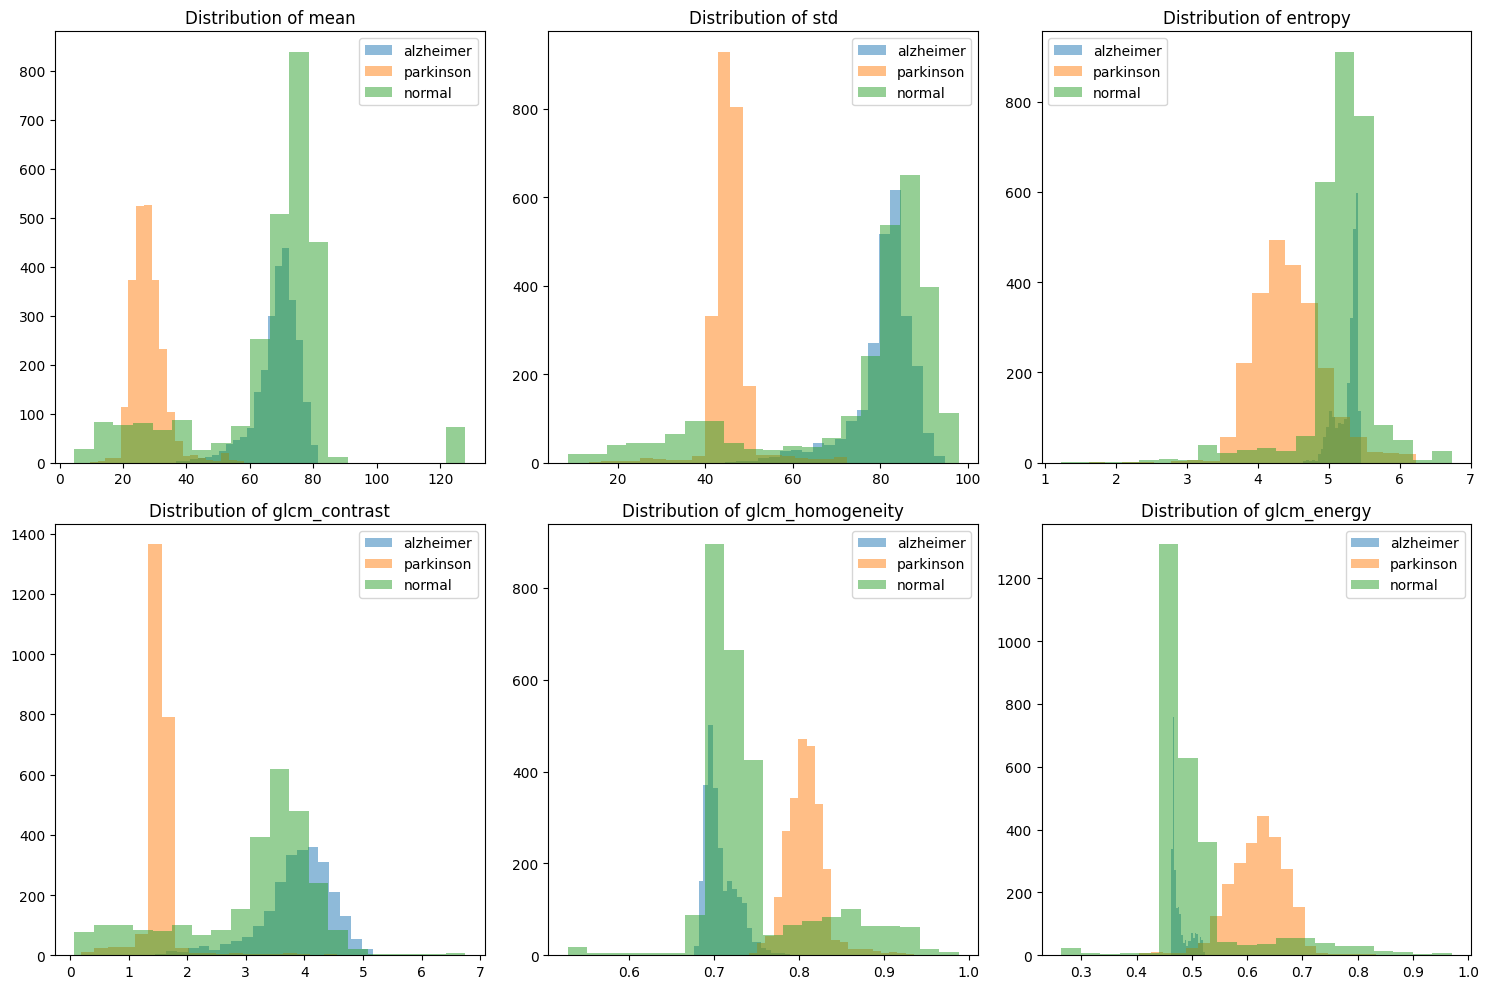

In [27]:
# Execute the feature extraction pipeline
if __name__ == "__main__":
    base_path = "E:/Rawan/Projects/Machine Learning/Project/Neurodegenerative-Diseases-Classifier/Data"
    classes = ["alzheimer", "parkinson", "normal"]

    # Process the dataset
    features_df = process_dataset()

    # Display the first few rows of the features DataFrame
    print(features_df.head())

    # Display basic statistics
    print("\nFeature statistics:")
    print(features_df.describe())

    # Count the number of samples per class
    print("\nClass distribution:")
    print(features_df['class'].value_counts())

    # Visualize some key features
    plt.figure(figsize=(15, 10))

    # Plot histograms of some first-order features by class
    for i, feature in enumerate(['mean', 'std', 'entropy']):
        plt.subplot(2, 3, i+1)
        for cls in classes:
            plt.hist(features_df[features_df['class'] == cls][feature], alpha=0.5, label=cls, bins=20)
        plt.title(f'Distribution of {feature}')
        plt.legend()

    # Plot histograms of some GLCM features by class
    for i, feature in enumerate(['glcm_contrast', 'glcm_homogeneity', 'glcm_energy']):
        plt.subplot(2, 3, i+4)
        for cls in classes:
            plt.hist(features_df[features_df['class'] == cls][feature], alpha=0.5, label=cls, bins=20)
        plt.title(f'Distribution of {feature}')
        plt.legend()

    plt.tight_layout()
    plt.savefig('feature_distributions.png')
    plt.show()

In [6]:
# For Feature Selection

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,RFE
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr, ttest_ind
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Feature Selector Class

class FeatureSelector:
    def __init__(self, X, y, feature_names=None):
        """
        Initialize the feature selector

        Parameters:
        -----------
        X : array-like
            Feature matrix
        y : array-like
            Target labels
        feature_names : list or array-like
            Names of the features
        """
        self.X = X
        # Encode the target variable
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(y)
        self.y_original = y  # Keep original labels for display
        # Convert feature_names to list if it's a pandas Index
        self.feature_names = list(feature_names) if feature_names is not None else [f'feature_{i}' for i in range(X.shape[1])]
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(X)

    def statistical_selection(self, k=10, method='f_classif'):

        if method == 'f_classif':
            selector = SelectKBest(f_classif, k=k)
            scores = f_classif(self.X_scaled, self.y)[0]
        else:
            selector = SelectKBest(mutual_info_classif, k=k)
            scores = mutual_info_classif(self.X_scaled, self.y)

        selector.fit(self.X_scaled, self.y)
        selected_indices = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_indices]

        return selected_features, scores


    def random_forest_selection(self, k=10, n_estimators=100):

        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf.fit(self.X_scaled, self.y)
        importances = rf.feature_importances_

        # Get indices of top k features
        selected_indices = np.argsort(importances)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]

        return selected_features, importances


    def pca_selection(self, n_components=0.95):

        pca = PCA(n_components=n_components)
        pca.fit(self.X_scaled)
        return pca.explained_variance_ratio_


    def plot_pca_variance(self, explained_variance_ratio):

        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(explained_variance_ratio), 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('PCA Explained Variance Ratio')
        plt.grid(True)
        plt.show()


    def evaluate_selection(self, selected_features, method_name):

        # Get indices of selected features using list comprehension
        selected_indices = [i for i, f in enumerate(self.feature_names) if f in selected_features]
        X_selected = self.X_scaled[:, selected_indices]

        # Evaluate using Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        scores = cross_val_score(rf, X_selected, self.y, cv=5)

        print(f"\n{method_name} Results:")
        print(f"Number of selected features: {len(selected_features)}")
        print(f"Cross-validation accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
        print("\nSelected features:")
        for feature in selected_features:
            print(f"- {feature}")
        print("\nClass mapping:")
        for i, label in enumerate(self.label_encoder.classes_):
            print(f"{i}: {label}")


    def correlation_selection(self, k=10, threshold=0.8):

        # Calculate correlation with target
        correlations = []
        for i in range(self.X.shape[1]):
            corr, _ = pearsonr(self.X_scaled[:, i], self.y)
            correlations.append(abs(corr))

        correlations = np.array(correlations)

        # Select features with highest correlation to target
        # while ensuring low correlation between selected features
        selected_indices = []
        remaining_indices = list(range(self.X.shape[1]))

        while len(selected_indices) < k and remaining_indices:
            # Find feature with highest correlation to target
            best_idx = remaining_indices[np.argmax(correlations[remaining_indices])]
            selected_indices.append(best_idx)

            # Remove highly correlated features
            if len(remaining_indices) > 1:
                corr_matrix = np.corrcoef(self.X_scaled[:, remaining_indices].T)
                to_remove = []
                for i, idx in enumerate(remaining_indices):
                    if idx != best_idx:
                        if abs(corr_matrix[remaining_indices.index(best_idx), i]) > threshold:
                            to_remove.append(idx)
                remaining_indices = [idx for idx in remaining_indices if idx not in to_remove]
            remaining_indices.remove(best_idx)

        selected_features = [self.feature_names[i] for i in selected_indices]
        return selected_features, correlations


    def lasso_selection(self, k=10):

        # Use LogisticRegression with L1 penalty for classification
        lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
        lasso.fit(self.X_scaled, self.y)

        # Get absolute coefficients
        coefficients = np.abs(lasso.coef_[0])  # Take first class coefficients

        # Select top k features
        selected_indices = np.argsort(coefficients)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]

        return selected_features, coefficients


    def rfe_selection(self, k=10, n_estimators=100):

        estimator = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rfe = RFE(estimator=estimator, n_features_to_select=k, step=1)
        rfe.fit(self.X_scaled, self.y)

        selected_indices = np.where(rfe.support_)[0]
        selected_features = [self.feature_names[i] for i in selected_indices]

        return selected_features, rfe.ranking_


    def chi2_selection(self, k=10):

        # Ensure data is non-negative for chi2
        X_positive = self.X_scaled - self.X_scaled.min() + 1e-6

        selector = SelectKBest(chi2, k=k)
        selector.fit(X_positive, self.y)

        selected_indices = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_indices]

        return selected_features, selector.scores_


    def ttest_selection(self, k=10, alpha=0.05):

        classes = np.unique(self.y)
        n_features = self.X_scaled.shape[1]
        min_pvalues = np.ones(n_features)

        # Perform t-test for each pair of classes
        for i in range(len(classes)):
            for j in range(i+1, len(classes)):
                class1 = self.X_scaled[self.y == classes[i]]
                class2 = self.X_scaled[self.y == classes[j]]

                # Perform t-test for each feature
                t_stats, p_values = ttest_ind(class1, class2)
                min_pvalues = np.minimum(min_pvalues, p_values)

        # Select features with smallest p-values
        selected_indices = np.argsort(min_pvalues)[:k]
        selected_features = [self.feature_names[i] for i in selected_indices]

        return selected_features, -np.log10(min_pvalues)  # Convert to -log10(p-value) for better visualization


    def elastic_net_selection(self, k=10, l1_ratio=0.5):

        # Use LogisticRegression with elastic net penalty
        elastic_net = LogisticRegression(penalty='elasticnet', solver='saga',
                                        l1_ratio=l1_ratio, random_state=42, max_iter=1000)
        elastic_net.fit(self.X_scaled, self.y)

        # Get absolute coefficients
        coefficients = np.abs(elastic_net.coef_[0])  # Take first class coefficients

        # Select top k features
        selected_indices = np.argsort(coefficients)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]

        return selected_features, coefficients


    def svm_based_selection(self, k=10):

        # Use LinearSVC with L1 regularization
        svm = LinearSVC(penalty='l1', dual=False, random_state=42)
        svm.fit(self.X_scaled, self.y)

        # Get absolute coefficients
        coefficients = np.abs(svm.coef_).mean(axis=0)  # Average across classes

        # Select top k features
        selected_indices = np.argsort(coefficients)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]

        return selected_features, coefficients


    def gradient_boosting_selection(self, k=10, n_estimators=100):

        gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
        gb.fit(self.X_scaled, self.y)

        # Get feature importances
        importances = gb.feature_importances_

        # Select top k features
        selected_indices = np.argsort(importances)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]

        return selected_features, importances


    def find_optimal_features(self, method='f_classif', feature_range=None, n_estimators=100):

        if feature_range is None:
            feature_range = [5, 10, 15, 20, 25, 30]

        results = {'k': [], 'score': [], 'std': []}
        best_score = -np.inf
        best_k = None

        for k in feature_range:
            if k > self.X.shape[1]:
                continue

            try:
                if method == 'f_classif':
                    selected_features, _ = self.statistical_selection(k=k, method='f_classif')
                elif method == 'mutual_info':
                    selected_features, _ = self.statistical_selection(k=k, method='mutual_info')
                elif method == 'random_forest':
                    selected_features, _ = self.random_forest_selection(k=k, n_estimators=n_estimators)
                elif method == 'correlation':
                    selected_features, _ = self.correlation_selection(k=k)
                elif method == 'lasso':
                    selected_features, _ = self.lasso_selection(k=k)
                elif method == 'rfe':
                    selected_features, _ = self.rfe_selection(k=k, n_estimators=n_estimators)
                elif method == 'chi2':
                    selected_features, _ = self.chi2_selection(k=k)
                elif method == 'ttest':
                    selected_features, _ = self.ttest_selection(k=k)
                elif method == 'elastic_net':
                    selected_features, _ = self.elastic_net_selection(k=k)
                elif method == 'svm':
                    selected_features, _ = self.svm_based_selection(k=k)
                elif method == 'gradient_boosting':
                    selected_features, _ = self.gradient_boosting_selection(k=k, n_estimators=n_estimators)
                else:
                    raise ValueError(f"Unknown method: {method}")

                # Get indices of selected features using list comprehension
                selected_indices = [i for i, f in enumerate(self.feature_names) if f in selected_features]
                X_selected = self.X_scaled[:, selected_indices]

                # Evaluate using Random Forest
                rf = RandomForestClassifier(n_estimators=100, random_state=42)
                scores = cross_val_score(rf, X_selected, self.y, cv=5)
                mean_score = scores.mean()
                std_score = scores.std()

                results['k'].append(k)
                results['score'].append(mean_score)
                results['std'].append(std_score)

                if mean_score > best_score:
                    best_score = mean_score
                    best_k = k

            except Exception as e:
                print(f"Error with k={k}: {str(e)}")
                continue

        if not results['k']:  # If no successful runs
            raise ValueError(f"No successful feature selection runs for method {method}")

        # Plot results
        plt.figure(figsize=(10, 6))
        plt.errorbar(results['k'], results['score'], yerr=results['std'], fmt='o-', capsize=5)
        plt.xlabel('Number of Features')
        plt.ylabel('Cross-validation Score')
        plt.title(f'Feature Selection Performance - {method}')
        plt.grid(True)
        plt.show()

        return best_k, best_score, results

Dataset shape: (7590, 55)
Number of features: 54
Number of samples: 7590
Class distribution:
class
normal       2699
alzheimer    2500
parkinson    2391
Name: count, dtype: int64

Finding optimal features using f_classif...


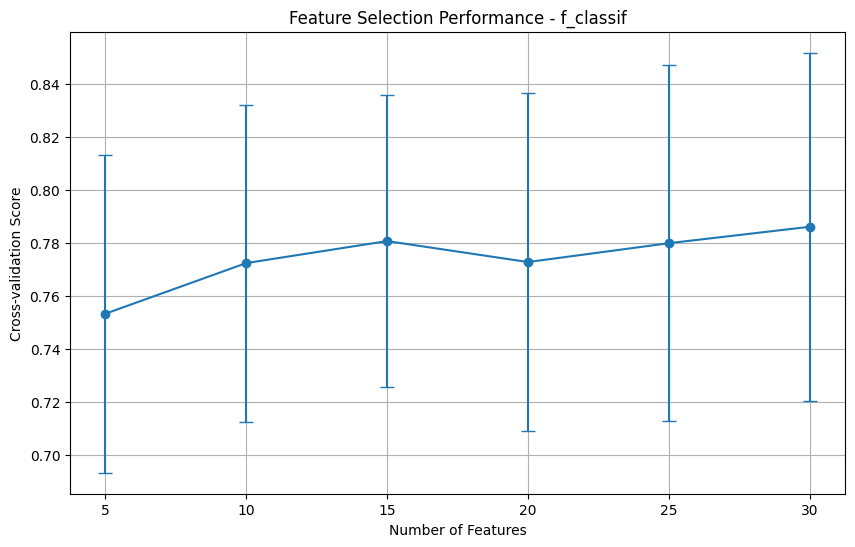

Best number of features: 30
Best cross-validation score: 0.786

Finding optimal features using mutual_info...


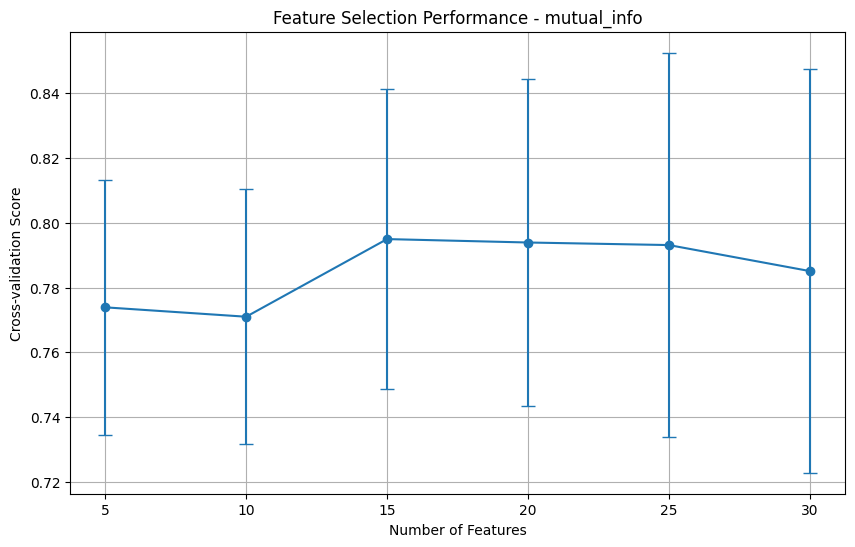

Best number of features: 15
Best cross-validation score: 0.795

Finding optimal features using random_forest...


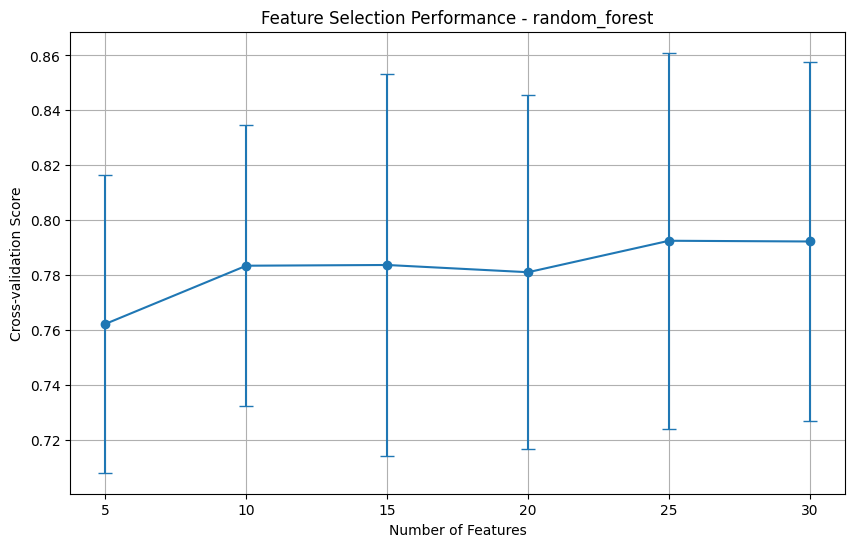

Best number of features: 25
Best cross-validation score: 0.792

Finding optimal features using correlation...


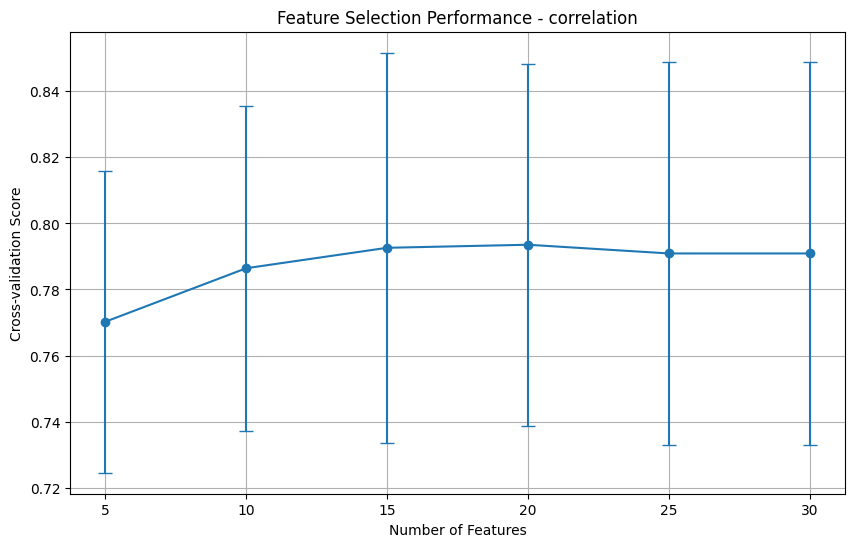

Best number of features: 20
Best cross-validation score: 0.794

Finding optimal features using lasso...


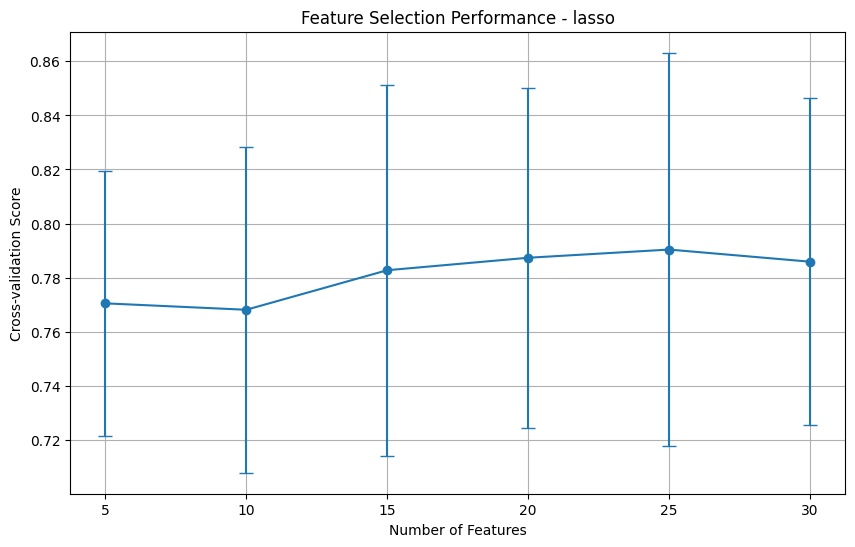

Best number of features: 25
Best cross-validation score: 0.790

Finding optimal features using rfe...


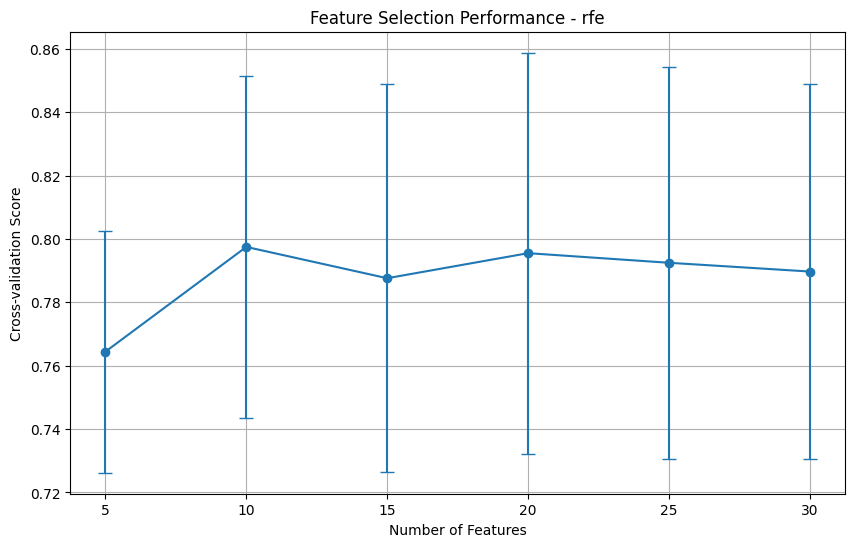

Best number of features: 10
Best cross-validation score: 0.797

Finding optimal features using ttest...


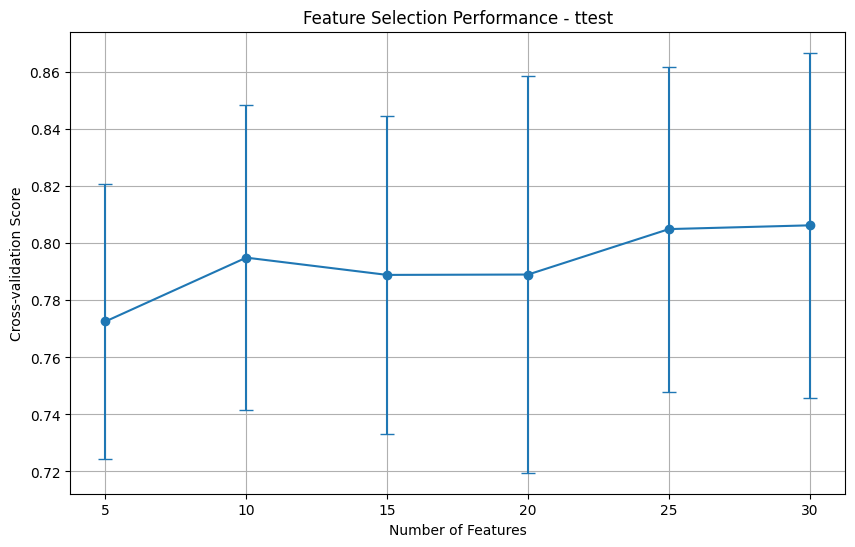

Best number of features: 30
Best cross-validation score: 0.806

Finding optimal features using elastic_net...


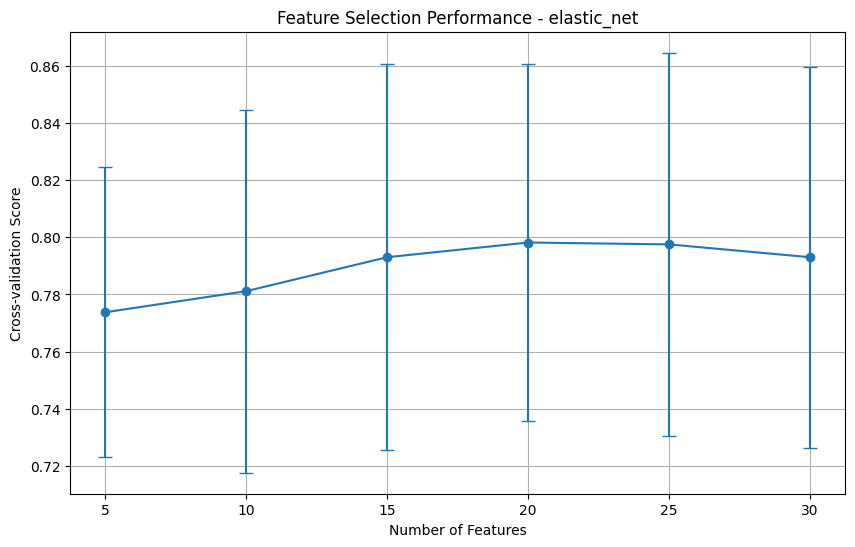

Best number of features: 20
Best cross-validation score: 0.798

Finding optimal features using svm...


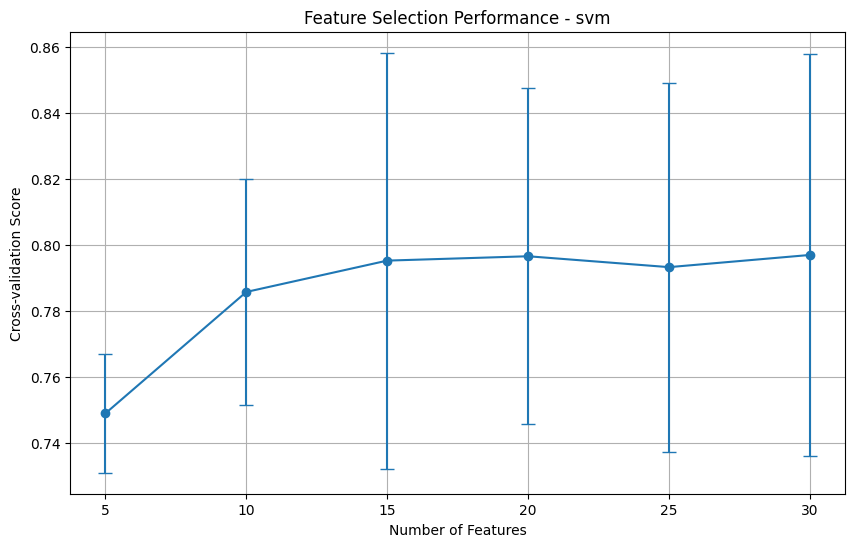

Best number of features: 30
Best cross-validation score: 0.797

Finding optimal features using gradient_boosting...


KeyboardInterrupt: 

In [8]:
# Read the data from csv file
data = pd.read_csv('brain_mri_features.csv')

# Drop the filename column as it's not needed for feature selection
data = data.drop(columns=['filename'])

# Separate features and target
X = data.drop(columns=['class'])
y = data['class']

# Convert feature names to list
feature_names = list(X.columns)

# Print some information about the dataset
print(f"Dataset shape: {data.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution:\n{y.value_counts()}")

# Initialize feature selector with list of feature names
selector = FeatureSelector(X, y, feature_names)

# Find optimal number of features for each method
methods = [
    'f_classif',  # Fisher Score
    'mutual_info',
    'random_forest',
    'correlation',
    'lasso',
    'rfe',
    'ttest',
    'elastic_net',
    'svm',
    'gradient_boosting'
]
best_results = {}

for method in methods:
    print(f"\nFinding optimal features using {method}...")
    try:

        feature_range = [5, 10, 15, 20, 25, 30]
        best_k, best_score, results = selector.find_optimal_features(method=method, feature_range=feature_range)
        best_results[method] = {
            'best_k': best_k,
            'best_score': best_score,
            'all_results': results
        }
        print(f"Best number of features: {best_k}")
        print(f"Best cross-validation score: {best_score:.3f}")
    except Exception as e:
        print(f"Error with {method}: {str(e)}")
        continue

# Use the best method and optimal k
if best_results:
    best_method = max(best_results.items(), key=lambda x: x[1]['best_score'])[0]
    best_k = best_results[best_method]['best_k']

    print(f"\nBest performing method: {best_method}")
    print(f"Optimal number of features: {best_k}")

    # Get final selected features using the best method and k
    if best_method == 'f_classif':  # Fisher Score
        selected_features, scores = selector.statistical_selection(k=best_k, method='f_classif')
    elif best_method == 'mutual_info':
        selected_features, scores = selector.statistical_selection(k=best_k, method='mutual_info')
    elif best_method == 'random_forest':
        selected_features, scores = selector.random_forest_selection(k=best_k)
    elif best_method == 'correlation':
        selected_features, scores = selector.correlation_selection(k=best_k)
    elif best_method == 'lasso':
        selected_features, scores = selector.lasso_selection(k=best_k)
    elif best_method == 'rfe':
        selected_features, scores = selector.rfe_selection(k=best_k)
    elif best_method == 'ttest':
        selected_features, scores = selector.ttest_selection(k=best_k)
    elif best_method == 'elastic_net':
        selected_features, scores = selector.elastic_net_selection(k=best_k)
    elif best_method == 'svm':
        selected_features, scores = selector.svm_based_selection(k=best_k)
    elif best_method == 'gradient_boosting':
        selected_features, scores = selector.gradient_boosting_selection(k=best_k)

    # Evaluate the selected features
    selector.evaluate_selection(selected_features, f'Best Method ({best_method})')

    # Save selected features to a file
    results = {
        'Method': [best_method] * len(selected_features),
        'Selected_Features': selected_features,
        'Optimal_k': [best_k] * len(selected_features),
        'Best_Score': [best_results[best_method]['best_score']] * len(selected_features)
    }

    # Add comparison of all methods
    comparison = pd.DataFrame({
        'Method': list(best_results.keys()),
        'Best_k': [results['best_k'] for results in best_results.values()],
        'Best_Score': [results['best_score'] for results in best_results.values()]
    })

    # Save results to CSV files
    pd.DataFrame(results).to_csv('selected_features.csv', index=False)
    comparison.to_csv('method_comparison.csv', index=False)
    print("\nSelected features have been saved to 'selected_features.csv'")
    print("Method comparison has been saved to 'method_comparison.csv'")
else:
    print("No methods were successful in finding optimal features.")

In [1]:
# For Training and Testing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_curve, auc
from scipy.stats import uniform
from sklearn.multiclass import OneVsRestClassifier
RANDOM_STATE = 42 # For reproducibility

# Load the main dataset
main_df = pd.read_csv('brain_mri_features.csv')

# Load the selected feature names from the CSV
features_df = pd.read_csv('selected_features.csv')
selected_features = features_df['Selected_Features'].tolist()

# Split data into features and target class
X = main_df[selected_features]  # Selected features data
y = main_df['class']  # ['Alzheimer', 'Parkinson', 'Normal']

# Standardize features to mean = 0 and variance = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Stratified Train-Test Split (80% Training, 20% Testing, Maintaining class ratios by stratifying)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [2]:
# Hyperparameter Tuning

# Define hyperparameter distribution for random search
param_dist = {
    'estimator__C': uniform(0.1, 10),  # Regularization parameter (prevents overrfitting)
    'estimator__kernel': ['linear', 'rbf'], # Kernel Type (linear, RBF)
    'estimator__gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, 5)), # Kernel coefficient (controls the spread of the kernel)
}

# Create SVM classifier with One-vs-Rest strategy for multiclass
svc = OneVsRestClassifier(svm.SVC(probability=True, random_state=RANDOM_STATE)) # Probability parameter enables probability estimates (required for ROC curves)

# Setup randomized search with stratified 5-fold cross-validation for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), # Maintain class distribution in the 5 folds
    scoring='accuracy', # Optimization metric
    n_jobs=4,
    random_state=RANDOM_STATE,
)

# Perform hyperparameter search
random_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

Best Parameters: {'estimator__C': np.float64(9.522017556848526), 'estimator__gamma': np.float64(5.623413251903491), 'estimator__kernel': 'rbf'}
Best CV Accuracy: 0.8682457746049179


In [3]:
# Model Training

# Final Model Training & Evaluation
best_svm = random_search.best_estimator_
best_svm.fit(X_train, y_train)

# Make predictions
y_pred = best_svm.predict(X_test)
y_proba = best_svm.predict_proba(X_test)

# Compare Test accuracy with training accuracy to check for overfitting
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = best_svm.score(X_train, y_train)

In [4]:
# Showcasing Performance Metrics

def class_accuracy(y_true, y_pred, classes):
    class_acc = {}
    for cls in classes:
        idx = (y_true == cls)
        class_acc[cls] = accuracy_score(y_true[idx], y_pred[idx])
    return class_acc

print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
print(f"Training Set Accuracy: {train_accuracy:.4f}")

cls_acc = class_accuracy(y_test, y_pred, y.unique())
print("\nClass-wise Accuracy:")
for target_class, accurracy in cls_acc.items():
    print(f"{target_class}: {accurracy:.4f}")

# Performance Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y.unique()))


Test Set Accuracy: 0.8755
Training Set Accuracy: 0.9386

Class-wise Accuracy:
alzheimer: 0.8520
parkinson: 0.9749
normal: 0.8093

Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.81      0.85      0.83       500
   parkinson       0.84      0.81      0.82       540
      normal       0.99      0.97      0.98       478

    accuracy                           0.88      1518
   macro avg       0.88      0.88      0.88      1518
weighted avg       0.88      0.88      0.88      1518



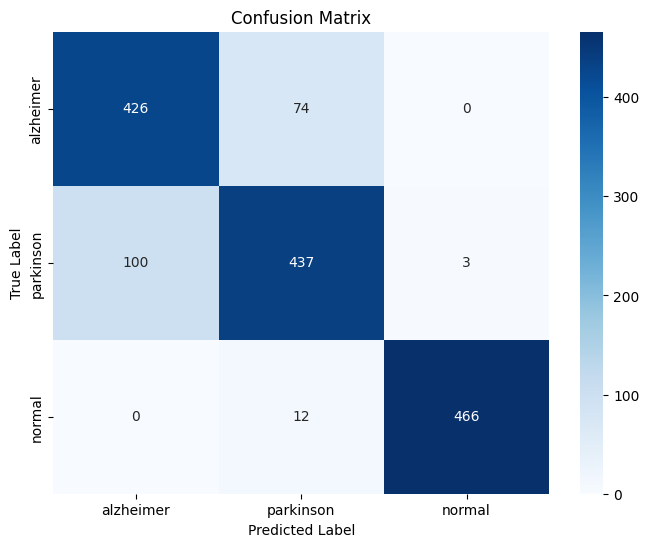

-----------------------------


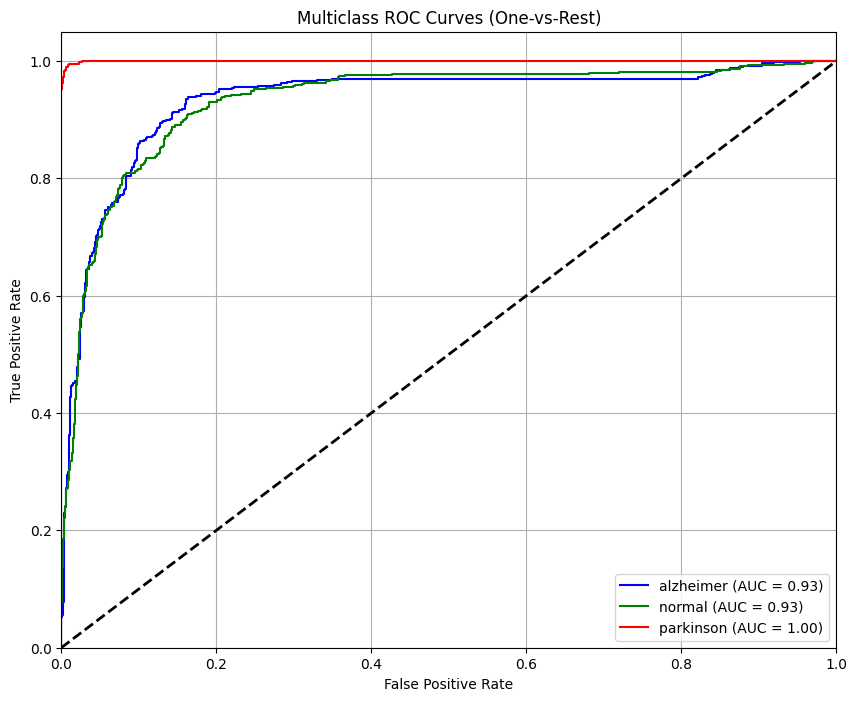

In [5]:
## Plotting Confusion Matrix & ROC Curve

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve_one_vs_rest(y_true, y_proba, class_names):
    # Convert labels to binary format for each class
    class_names = best_svm.classes_
    y_true_bin  = label_binarize(y_true, classes=class_names)

    # Initialize storage for ROC metrics
    fpr, tpr, roc_auc = {}, {}, {}

    # Calculate ROC metrics for each class
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'red']  # Each color has a class

    for i, color, class_name in zip(range(len(class_names)), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_confusion_matrix(y_test, y_pred, classes=y.unique())
print("-----------------------------")
plot_roc_curve_one_vs_rest(y_test, y_proba, y.unique())